# D&D Gameplay Log Analysis Tutorial

This notebook demonstrates how to analyze Dungeons & Dragons gameplay logs

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from dnd_dynamics.analysis import data_loading as dl
from dnd_dynamics.analysis import metrics
from dnd_dynamics.analysis import plot_utils as pu

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100

# Output directory
OUTPUT_DIR = Path('plots')
OUTPUT_DIR.mkdir(exist_ok=True)

Anthropic API key loaded
OpenAI API key loaded
Gemini API key loaded


# Configuration

In [2]:
# === CONFIGURATION ===

# Base campaign names to analyze
CAMPAIGN_BASE_NAMES = [
    '1262-firedeath-must-die-closed-play-by-post-open-ogg',
    '3135-the-head-of-the-serpent',
    '10391-guardians-of-gridori',
    '20049-age-of-death',
    '89221-banhaven-academy-year-1',
    '90630-firecat5s-dragon-of-icespire-peak',
    '7426-serpent-isle-private-campaign',
]

# LLM game filters
LLM_FILTER = {
    'model': ['gpt-4o', 'gemini-1.5-pro', 'claude-3-7-sonnet-latest'],
    'campaign_name': CAMPAIGN_BASE_NAMES,
    'include_player_personalities': [True, False],
    'year': 2025,
    'scratchpad': True,
}

# Category grouping - which metadata fields to group by for aggregation
CATEGORY_FIELDS = ['model', 'include_player_personalities']

# Analysis parameters
MESSAGES_PER_SESSION = 5
FORCE_REFRESH = False

# Output
OUTPUT_DIR = Path('plots')

In [3]:
# === DATA LOADING ===

# Load human campaigns
dfs_human = dl.load_campaigns(
    CAMPAIGN_BASE_NAMES,
    messages_per_session=MESSAGES_PER_SESSION
)

# Load LLM campaigns with filtering
dfs_llm = dl.load_campaigns(
    'llm',
    messages_per_session=MESSAGES_PER_SESSION,
    filter_by=LLM_FILTER
)

# Combine DataFrames
dfs = {**dfs_human, **dfs_llm}

print(f"Loaded {len(dfs_human)} human campaigns, {len(dfs_llm)} LLM campaigns")
print(f"Total: {len(dfs)} campaigns")

Filter matched 42 campaigns
Loading 42 campaigns from /Users/annie/Code/Repositories/dnd-dynamics/data/llm-games/game-logs


Loading campaigns: 100%|██████████| 42/42 [00:02<00:00, 19.18it/s]

Loaded 42 campaigns (10,215 messages)
Loaded 7 human campaigns, 42 LLM campaigns
Total: 49 campaigns


# Calculate game log analyses

In [4]:
# === METRICS CALCULATION ===

all_metrics = metrics.analyze_all(dfs, force_refresh=FORCE_REFRESH)

basic_metrics = all_metrics['basic']
semantic_metrics = all_metrics['semantic']
jaccard_metrics = all_metrics['jaccard']
dsi_metrics = all_metrics['dsi']

📁 Loaded 49 cached basic metrics results
📁 Loaded 49 cached jaccard results
📁 Loaded 49 cached semantic results
📁 Loaded 49 cached DSI results


In [5]:
# === LLM JUDGE CREATIVITY METRIC ===
# Note: This metric makes API calls and may take time/cost money

llm_judge_results = metrics.analyze_llm_judge_creativity(dfs, force_refresh=FORCE_REFRESH)

📁 Loaded 49 cached LLM judge creativity results


In [6]:
# === DATA PREPARATION ===

# Get ordered campaign names
campaign_names = list(dfs.keys())

# Categorize campaigns using metadata
categories = pu.categorize_campaigns(campaign_names, CATEGORY_FIELDS)

# Print category summary
print("Campaign categories:")
for cat, names in categories.items():
    print(f"  {cat}: {len(names)} campaigns")

Campaign categories:
  human: 7 campaigns
  model:claude-3-7-sonnet-latest, include_player_personalities:False: 7 campaigns
  model:claude-3-7-sonnet-latest, include_player_personalities:True: 7 campaigns
  model:gemini-1.5-pro, include_player_personalities:False: 7 campaigns
  model:gemini-1.5-pro, include_player_personalities:True: 7 campaigns
  model:gpt-4o, include_player_personalities:False: 7 campaigns
  model:gpt-4o, include_player_personalities:True: 7 campaigns


In [7]:
# === MEAN METRICS PER CAMPAIGN ===

mean_session_cohesion = np.array([semantic_metrics[name].summary['mean_session_cohesion'] for name in campaign_names])
mean_sequential_cohesion = np.array([semantic_metrics[name].summary['mean_sequential_cohesion'] for name in campaign_names])
mean_jaccard_cohesion = np.array([jaccard_metrics[name].summary['mean_jaccard'] if jaccard_metrics[name] else np.nan for name in campaign_names])
mean_dsi_scores = np.array([dsi_metrics[name].summary['time_averaged_dsi'] for name in campaign_names])

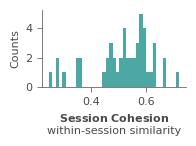

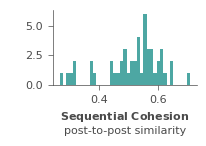

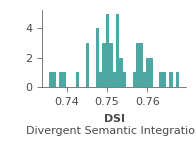

In [8]:
# Single histogram of mean values per campaign
plt.rcParams.update({'font.size': 8})

pu.plot_histogram(mean_session_cohesion,
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Session\ Cohesion}$' + '\nwithin-session similarity')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'session_cohesion.pdf', transparent=True)

pu.plot_histogram(mean_sequential_cohesion,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Sequential\ Cohesion}$' + '\npost-to-post similarity')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'sequential_cohesion.pdf', transparent=True)

pu.plot_histogram(mean_dsi_scores,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{DSI}$' + '\nDivergent Semantic Integration')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dsi.pdf', transparent=True)

In [9]:
# === COMBINED HISTOGRAMS (All Data) ===

time_intervals_all = np.concatenate([basic_metrics[name].series['time_intervals'] for name in campaign_names])
post_lengths_all = np.concatenate([basic_metrics[name].series['post_lengths'] for name in campaign_names])

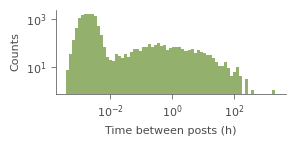

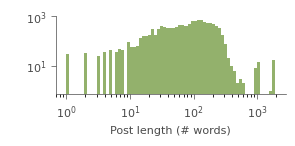

In [10]:
pu.plot_histogram(time_intervals_all,
               figsize=(3, 1.5),
               log_y=True,
               bins=70,
               colors=[[.4, 0.57, .18]],
               alpha=0.7,
               log_bins=True,
               xlabel='Time between posts (h)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'time_intervals.pdf', transparent=True)

pu.plot_histogram(post_lengths_all,
               colors=[[.4, 0.57, .18]],
               figsize=(3, 1.5),
               alpha=0.7,
               ylabel="   ",
               log_y=True,
               bins=70,
               log_bins=True,
               xlabel='Post length (# words)')
plt.tight_layout()

Aggregated category sizes:
  human: 1821 data points
  model:gemini-1.5-pro, include_player_personalities:False: 1812 data points
  model:gemini-1.5-pro, include_player_personalities:True: 1812 data points
  model:claude-3-7-sonnet-latest, include_player_personalities:False: 1449 data points
  model:claude-3-7-sonnet-latest, include_player_personalities:True: 1518 data points
  model:gpt-4o, include_player_personalities:False: 1812 data points
  model:gpt-4o, include_player_personalities:True: 1812 data points


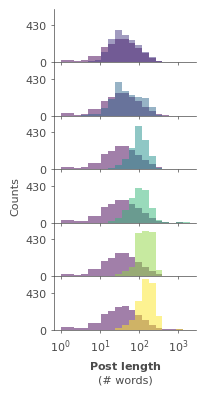

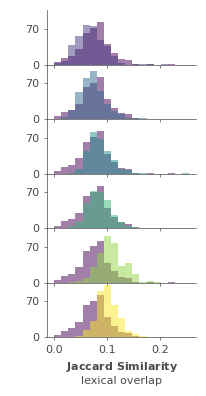

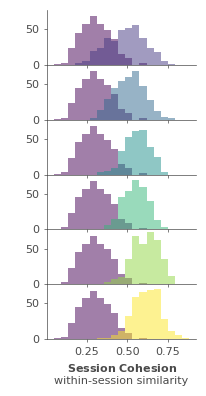

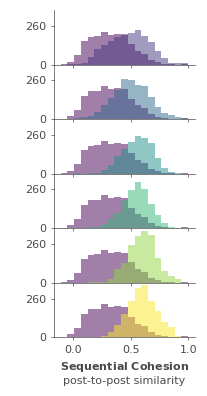

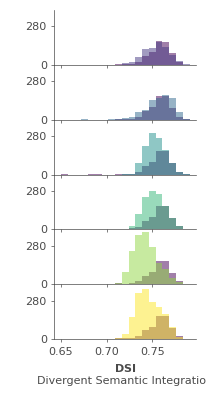

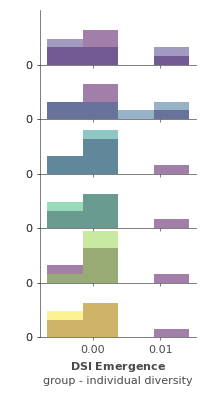

In [11]:
# === VISUALIZATION (Aggregated by Category) ===

# Define category display order (must match format from categorize_campaigns)
CATEGORY_ORDER = [
    'human',
    'model:gemini-1.5-pro, include_player_personalities:False',
    'model:gemini-1.5-pro, include_player_personalities:True',
    'model:claude-3-7-sonnet-latest, include_player_personalities:False',
    'model:claude-3-7-sonnet-latest, include_player_personalities:True',
    'model:gpt-4o, include_player_personalities:False',
    'model:gpt-4o, include_player_personalities:True',
]

# Aggregate by category using new API
post_len_agg, _ = pu.aggregate_metric(basic_metrics, campaign_names, categories, CATEGORY_ORDER, 'post_lengths')
jaccard_agg, _ = pu.aggregate_metric(jaccard_metrics, campaign_names, categories, CATEGORY_ORDER, 'jaccard_session')
session_cohesion_agg, _ = pu.aggregate_metric(semantic_metrics, campaign_names, categories, CATEGORY_ORDER, 'session_cohesion')
sequential_cohesion_agg, _ = pu.aggregate_metric(semantic_metrics, campaign_names, categories, CATEGORY_ORDER, 'sequential_cohesion')
dsi_agg, _ = pu.aggregate_metric(dsi_metrics, campaign_names, categories, CATEGORY_ORDER, 'dsi_scores')
dsi_emergence_agg, _ = pu.aggregate_metric(dsi_metrics, campaign_names, categories, CATEGORY_ORDER, 'dsi_emergence')

# Check category sizes
print("Aggregated category sizes:")
for i, cat in enumerate(CATEGORY_ORDER):
    print(f"  {cat}: {len(post_len_agg[i])} data points")

plt.rcParams.update({'font.size': 8})

# Post length comparison
pu.plot_comparison_histograms(
    post_len_agg,
    bins=20,
    log_bins=True,
    log_y=False,
    xlabel=r'$\mathbf{Post\ length}$' + '\n(# words)',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_len.pdf', transparent=True)

# Jaccard similarity comparison
pu.plot_comparison_histograms(
    jaccard_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Jaccard\ Similarity}$' + '\nlexical overlap',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_jaccard.pdf', transparent=True)

# Session cohesion comparison
pu.plot_comparison_histograms(
    session_cohesion_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Session\ Cohesion}$' + '\nwithin-session similarity',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_session_cohesion.pdf', transparent=True)

# Sequential cohesion comparison
pu.plot_comparison_histograms(
    sequential_cohesion_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Sequential\ Cohesion}$' + '\npost-to-post similarity',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_sequential_cohesion.pdf', transparent=True)

# DSI comparison
pu.plot_comparison_histograms(
    dsi_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{DSI}$' + '\nDivergent Semantic Integration',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_dsi.pdf', transparent=True)

# DSI Emergence comparison
pu.plot_comparison_histograms(
    dsi_emergence_agg,
    bins=5,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{DSI\ Emergence}$' + '\ngroup - individual diversity',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_dsi_emergence.pdf', transparent=True)

627
627
627
627


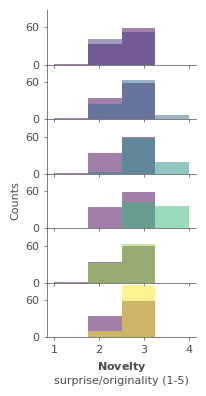

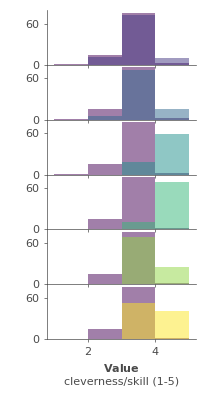

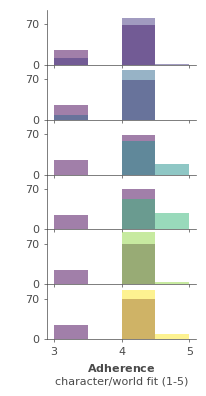

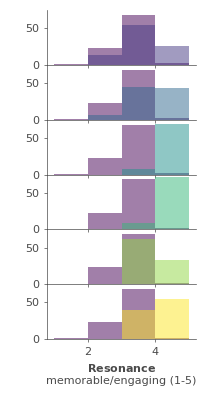

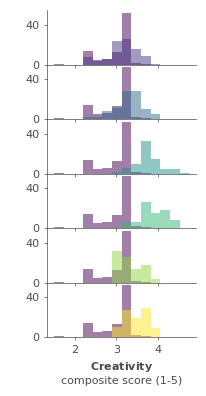

In [12]:
# === LLM JUDGE CREATIVITY COMPARISON HISTOGRAMS ===

# Aggregate creativity dimensions by category
novelty_agg, _ = pu.aggregate_metric(llm_judge_results, campaign_names, categories, CATEGORY_ORDER, 'novelty')
print(len(np.concatenate(novelty_agg)))
value_agg, _ = pu.aggregate_metric(llm_judge_results, campaign_names, categories, CATEGORY_ORDER, 'value')
print(len(np.concatenate(value_agg)))
adherence_agg, _ = pu.aggregate_metric(llm_judge_results, campaign_names, categories, CATEGORY_ORDER, 'adherence')
print(len(np.concatenate(adherence_agg)))
resonance_agg, _ = pu.aggregate_metric(llm_judge_results, campaign_names, categories, CATEGORY_ORDER, 'resonance')
print(len(np.concatenate(resonance_agg)))
creativity_agg, _ = pu.aggregate_metric(llm_judge_results, campaign_names, categories, CATEGORY_ORDER, 'creativity')

# Novelty comparison
pu.plot_comparison_histograms(
    novelty_agg,
    bins=5,
    log_bins=False,
    xlabel=r'$\mathbf{Novelty}$' + '\nsurprise/originality (1-5)',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_novelty.pdf', transparent=True)

# Value comparison
pu.plot_comparison_histograms(
    value_agg,
    bins=5,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Value}$' + '\ncleverness/skill (1-5)',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_value.pdf', transparent=True)

# Adherence comparison
pu.plot_comparison_histograms(
    adherence_agg,
    bins=5,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Adherence}$' + '\ncharacter/world fit (1-5)',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_adherence.pdf', transparent=True)

# Resonance comparison
pu.plot_comparison_histograms(
    resonance_agg,
    bins=5,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Resonance}$' + '\nmemorable/engaging (1-5)',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_resonance.pdf', transparent=True)

# Composite Creativity comparison (average of all dimensions)
pu.plot_comparison_histograms(
    creativity_agg,
    bins=15,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Creativity}$' + '\ncomposite score (1-5)',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_creativity.pdf', transparent=True)

📁 Loaded 49 cached Conflict results


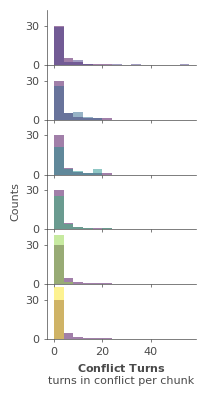

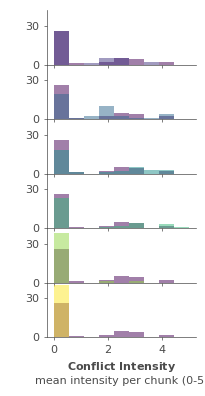

In [13]:
# === LLM CONFLICT ANALYSIS ===
# Note: This metric makes API calls and may take time/cost money

conflict_results = metrics.analyze_conflict(dfs, force_refresh=FORCE_REFRESH)

# Aggregate conflict metrics by category
conflict_turns_agg, _ = pu.aggregate_metric(conflict_results, campaign_names, categories, CATEGORY_ORDER, 'conflict_turns')
mean_intensity_agg, _ = pu.aggregate_metric(conflict_results, campaign_names, categories, CATEGORY_ORDER, 'mean_intensity')

# Conflict turns per chunk comparison
pu.plot_comparison_histograms(
    conflict_turns_agg,
    bins=15,
    log_bins=False,
    xlabel=r'$\mathbf{Conflict\ Turns}$' + '\nturns in conflict per chunk',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_conflict_turns.pdf', transparent=True)

# Mean intensity per chunk comparison
pu.plot_comparison_histograms(
    mean_intensity_agg,
    bins=10,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Conflict\ Intensity}$' + '\nmean intensity per chunk (0-5)',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_conflict_intensity.pdf', transparent=True)

📁 Loaded 49 cached Humor results


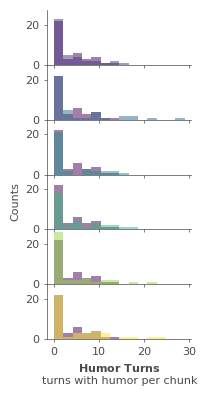

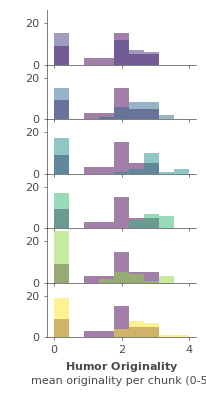

In [14]:
# === LLM HUMOR ANALYSIS ===
# Note: This metric makes API calls and may take time/cost money

humor_results = metrics.analyze_humor(dfs, force_refresh=FORCE_REFRESH)

# Aggregate humor metrics by category
humor_turns_agg, _ = pu.aggregate_metric(humor_results, campaign_names, categories, CATEGORY_ORDER, 'humor_turns')
mean_originality_agg, _ = pu.aggregate_metric(humor_results, campaign_names, categories, CATEGORY_ORDER, 'mean_originality')

# Humor turns per chunk comparison
pu.plot_comparison_histograms(
    humor_turns_agg,
    bins=15,
    log_bins=False,
    xlabel=r'$\mathbf{Humor\ Turns}$' + '\nturns with humor per chunk',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_humor_turns.pdf', transparent=True)

# Mean originality per chunk comparison
pu.plot_comparison_histograms(
    mean_originality_agg,
    bins=10,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Humor\ Originality}$' + '\nmean originality per chunk (0-5)',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_humor_originality.pdf', transparent=True)

📁 Loaded 49 cached Cooperation results


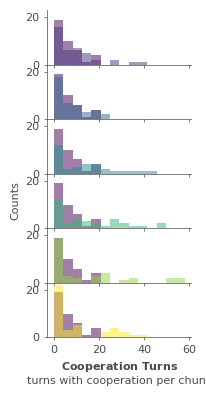

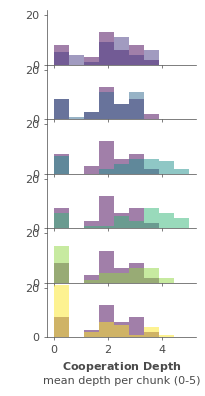

In [15]:
# === LLM COOPERATION ANALYSIS ===
# Note: This metric makes API calls and may take time/cost money

cooperation_results = metrics.analyze_cooperation(dfs, force_refresh=FORCE_REFRESH)

# Aggregate cooperation metrics by category
cooperation_turns_agg, _ = pu.aggregate_metric(cooperation_results, campaign_names, categories, CATEGORY_ORDER, 'cooperation_turns')
mean_depth_agg, _ = pu.aggregate_metric(cooperation_results, campaign_names, categories, CATEGORY_ORDER, 'mean_depth')

# Cooperation turns per chunk comparison
pu.plot_comparison_histograms(
    cooperation_turns_agg,
    bins=15,
    log_bins=False,
    xlabel=r'$\mathbf{Cooperation\ Turns}$' + '\nturns with cooperation per chunk',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_cooperation_turns.pdf', transparent=True)

# Mean depth per chunk comparison
pu.plot_comparison_histograms(
    mean_depth_agg,
    bins=10,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Cooperation\ Depth}$' + '\nmean depth per chunk (0-5)',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_cooperation_depth.pdf', transparent=True)

Analyzing norms in 49 campaign(s)...
Campaign 1/49: 1262-firedeath-must-die-closed-play-by-post-open-ogg (502 turns)
  Extracting from 2 window(s)...


  1262-firedeath-must-die-closed-play-by-post-open-ogg extraction: 100%|██████████| 2/2 [00:04<00:00,  2.45s/window]


  Found 7 norm episode(s) across 5 unique norm(s) in 11 chunk(s)
Campaign 2/49: 3135-the-head-of-the-serpent (300 turns)
  Extracting from 1 window(s)...


  3135-the-head-of-the-serpent extraction: 100%|██████████| 1/1 [00:01<00:00,  1.67s/window]


  Found 2 norm episode(s) across 2 unique norm(s) in 6 chunk(s)
Campaign 3/49: 10391-guardians-of-gridori (216 turns)
  Extracting from 1 window(s)...


  10391-guardians-of-gridori extraction: 100%|██████████| 1/1 [00:04<00:00,  4.60s/window]


  Found 6 norm episode(s) across 3 unique norm(s) in 5 chunk(s)
Campaign 4/49: 20049-age-of-death (186 turns)
  Extracting from 1 window(s)...


  20049-age-of-death extraction: 100%|██████████| 1/1 [00:01<00:00,  1.74s/window]


  Found 0 norm episode(s) across 0 unique norm(s) in 4 chunk(s)
Campaign 5/49: 89221-banhaven-academy-year-1 (317 turns)
  Extracting from 1 window(s)...


  89221-banhaven-academy-year-1 extraction: 100%|██████████| 1/1 [00:03<00:00,  3.46s/window]


  Found 4 norm episode(s) across 4 unique norm(s) in 7 chunk(s)
Campaign 6/49: 90630-firecat5s-dragon-of-icespire-peak (230 turns)
  Extracting from 1 window(s)...


  90630-firecat5s-dragon-of-icespire-peak extraction: 100%|██████████| 1/1 [00:04<00:00,  4.33s/window]


  Found 6 norm episode(s) across 4 unique norm(s) in 5 chunk(s)
Campaign 7/49: 7426-serpent-isle-private-campaign (70 turns)
  Extracting from 1 window(s)...


  7426-serpent-isle-private-campaign extraction: 100%|██████████| 1/1 [00:01<00:00,  1.80s/window]


  Found 2 norm episode(s) across 2 unique norm(s) in 2 chunk(s)
Campaign 8/49: 10391-guardians-of-gridori_claude-3-7-sonnet-latest_no_players_scratch_20250815_090708 (214 turns)
  Extracting from 1 window(s)...


  10391-guardians-of-gridori_claude-3-7-sonnet-latest_no_players_scratch_20250815_090708 extraction: 100%|██████████| 1/1 [00:09<00:00,  9.21s/window]


  Found 24 norm episode(s) across 6 unique norm(s) in 5 chunk(s)
Campaign 9/49: 10391-guardians-of-gridori_claude-3-7-sonnet-latest_players_scratch_20250814_143138 (202 turns)
  Extracting from 1 window(s)...


  10391-guardians-of-gridori_claude-3-7-sonnet-latest_players_scratch_20250814_143138 extraction: 100%|██████████| 1/1 [00:07<00:00,  7.88s/window]


  Found 25 norm episode(s) across 7 unique norm(s) in 5 chunk(s)
Campaign 10/49: 10391-guardians-of-gridori_gemini-1.5-pro_no_players_scratch_20250817_183449 (214 turns)
  Extracting from 1 window(s)...


  10391-guardians-of-gridori_gemini-1.5-pro_no_players_scratch_20250817_183449 extraction: 100%|██████████| 1/1 [00:03<00:00,  3.07s/window]


  Found 4 norm episode(s) across 4 unique norm(s) in 5 chunk(s)
Campaign 11/49: 10391-guardians-of-gridori_gemini-1.5-pro_players_scratch_20250817_181454 (214 turns)
  Extracting from 1 window(s)...


  10391-guardians-of-gridori_gemini-1.5-pro_players_scratch_20250817_181454 extraction: 100%|██████████| 1/1 [00:10<00:00, 10.85s/window]


  Found 22 norm episode(s) across 2 unique norm(s) in 5 chunk(s)
Campaign 12/49: 10391-guardians-of-gridori_gpt-4o_no_players_scratch_20250814_131744 (214 turns)
  Extracting from 1 window(s)...


  10391-guardians-of-gridori_gpt-4o_no_players_scratch_20250814_131744 extraction: 100%|██████████| 1/1 [00:01<00:00,  1.71s/window]


  Found 1 norm episode(s) across 1 unique norm(s) in 5 chunk(s)
Campaign 13/49: 10391-guardians-of-gridori_gpt-4o_players_scratch_20250814_122435 (214 turns)
  Extracting from 1 window(s)...


  10391-guardians-of-gridori_gpt-4o_players_scratch_20250814_122435 extraction: 100%|██████████| 1/1 [00:02<00:00,  2.28s/window]


  Found 2 norm episode(s) across 2 unique norm(s) in 5 chunk(s)
Campaign 14/49: 1262-firedeath-must-die-closed-play-by-post-open-ogg_claude-3-7-sonnet-latest_no_players_scratch_20250819_110000 (283 turns)
  Extracting from 1 window(s)...


  1262-firedeath-must-die-closed-play-by-post-open-ogg_claude-3-7-sonnet-latest_no_players_scratch_20250819_110000 extraction: 100%|██████████| 1/1 [00:07<00:00,  7.99s/window]


  Found 21 norm episode(s) across 6 unique norm(s) in 6 chunk(s)
Campaign 15/49: 1262-firedeath-must-die-closed-play-by-post-open-ogg_claude-3-7-sonnet-latest_players_scratch_20250819_132210 (245 turns)
  Extracting from 1 window(s)...


  1262-firedeath-must-die-closed-play-by-post-open-ogg_claude-3-7-sonnet-latest_players_scratch_20250819_132210 extraction: 100%|██████████| 1/1 [00:04<00:00,  4.82s/window]


  Found 11 norm episode(s) across 2 unique norm(s) in 5 chunk(s)
Campaign 16/49: 1262-firedeath-must-die-closed-play-by-post-open-ogg_gemini-1.5-pro_no_players_scratch_20250818_204449 (502 turns)
  Extracting from 2 window(s)...


  1262-firedeath-must-die-closed-play-by-post-open-ogg_gemini-1.5-pro_no_players_scratch_20250818_204449 extraction: 100%|██████████| 2/2 [00:04<00:00,  2.24s/window]


  Found 5 norm episode(s) across 4 unique norm(s) in 11 chunk(s)
Campaign 17/49: 1262-firedeath-must-die-closed-play-by-post-open-ogg_gemini-1.5-pro_players_scratch_20250818_145631 (502 turns)
  Extracting from 2 window(s)...


  1262-firedeath-must-die-closed-play-by-post-open-ogg_gemini-1.5-pro_players_scratch_20250818_145631 extraction: 100%|██████████| 2/2 [00:05<00:00,  2.87s/window]


  Found 11 norm episode(s) across 11 unique norm(s) in 11 chunk(s)
Campaign 18/49: 1262-firedeath-must-die-closed-play-by-post-open-ogg_gpt-4o_no_players_scratch_20250816_110159 (502 turns)
  Extracting from 2 window(s)...


  1262-firedeath-must-die-closed-play-by-post-open-ogg_gpt-4o_no_players_scratch_20250816_110159 extraction: 100%|██████████| 2/2 [00:24<00:00, 12.24s/window]


  Found 42 norm episode(s) across 3 unique norm(s) in 10 chunk(s)
Campaign 19/49: 1262-firedeath-must-die-closed-play-by-post-open-ogg_gpt-4o_players_scratch_20250816_125646 (502 turns)
  Extracting from 2 window(s)...


  1262-firedeath-must-die-closed-play-by-post-open-ogg_gpt-4o_players_scratch_20250816_125646 extraction: 100%|██████████| 2/2 [00:14<00:00,  7.22s/window]


  Found 27 norm episode(s) across 6 unique norm(s) in 10 chunk(s)
Campaign 20/49: 20049-age-of-death_claude-3-7-sonnet-latest_no_players_scratch_20250818_133738 (183 turns)
  Extracting from 1 window(s)...


  20049-age-of-death_claude-3-7-sonnet-latest_no_players_scratch_20250818_133738 extraction: 100%|██████████| 1/1 [00:04<00:00,  4.16s/window]


  Found 8 norm episode(s) across 4 unique norm(s) in 4 chunk(s)
Campaign 21/49: 20049-age-of-death_claude-3-7-sonnet-latest_players_scratch_20250818_120952 (183 turns)
  Extracting from 1 window(s)...


  20049-age-of-death_claude-3-7-sonnet-latest_players_scratch_20250818_120952 extraction: 100%|██████████| 1/1 [00:03<00:00,  3.14s/window]


  Found 4 norm episode(s) across 2 unique norm(s) in 4 chunk(s)
Campaign 22/49: 20049-age-of-death_gemini-1.5-pro_no_players_scratch_20250818_130018 (183 turns)
  Extracting from 1 window(s)...


  20049-age-of-death_gemini-1.5-pro_no_players_scratch_20250818_130018 extraction: 100%|██████████| 1/1 [00:02<00:00,  2.45s/window]


  Found 3 norm episode(s) across 1 unique norm(s) in 4 chunk(s)
Campaign 23/49: 20049-age-of-death_gemini-1.5-pro_players_scratch_20250818_122503 (183 turns)
  Extracting from 1 window(s)...


  20049-age-of-death_gemini-1.5-pro_players_scratch_20250818_122503 extraction: 100%|██████████| 1/1 [00:02<00:00,  2.34s/window]


  Found 3 norm episode(s) across 1 unique norm(s) in 4 chunk(s)
Campaign 24/49: 20049-age-of-death_gpt-4o_no_players_scratch_20250816_213933 (183 turns)
  Extracting from 1 window(s)...


  20049-age-of-death_gpt-4o_no_players_scratch_20250816_213933 extraction: 100%|██████████| 1/1 [00:01<00:00,  1.01s/window]


  Found 0 norm episode(s) across 0 unique norm(s) in 4 chunk(s)
Campaign 25/49: 20049-age-of-death_gpt-4o_players_scratch_20250816_212424 (183 turns)
  Extracting from 1 window(s)...


  20049-age-of-death_gpt-4o_players_scratch_20250816_212424 extraction: 100%|██████████| 1/1 [00:08<00:00,  8.01s/window]


  Found 3 norm episode(s) across 2 unique norm(s) in 4 chunk(s)
Campaign 26/49: 3135-the-head-of-the-serpent_claude-3-7-sonnet-latest_no_players_scratch_20250819_153636 (263 turns)
  Extracting from 1 window(s)...


  3135-the-head-of-the-serpent_claude-3-7-sonnet-latest_no_players_scratch_20250819_153636 extraction: 100%|██████████| 1/1 [00:05<00:00,  5.56s/window]


  Found 10 norm episode(s) across 3 unique norm(s) in 6 chunk(s)
Campaign 27/49: 3135-the-head-of-the-serpent_claude-3-7-sonnet-latest_players_scratch_20250818_154911 (299 turns)
  Extracting from 1 window(s)...


  3135-the-head-of-the-serpent_claude-3-7-sonnet-latest_players_scratch_20250818_154911 extraction: 100%|██████████| 1/1 [00:23<00:00, 23.61s/window]


  Found 5 norm episode(s) across 4 unique norm(s) in 6 chunk(s)
Campaign 28/49: 3135-the-head-of-the-serpent_gemini-1.5-pro_no_players_scratch_20250818_160148 (299 turns)
  Extracting from 1 window(s)...


  3135-the-head-of-the-serpent_gemini-1.5-pro_no_players_scratch_20250818_160148 extraction: 100%|██████████| 1/1 [00:02<00:00,  2.29s/window]


  Found 3 norm episode(s) across 3 unique norm(s) in 6 chunk(s)
Campaign 29/49: 3135-the-head-of-the-serpent_gemini-1.5-pro_players_scratch_20250818_153052 (299 turns)
  Extracting from 1 window(s)...


  3135-the-head-of-the-serpent_gemini-1.5-pro_players_scratch_20250818_153052 extraction: 100%|██████████| 1/1 [00:04<00:00,  4.62s/window]


  Found 6 norm episode(s) across 2 unique norm(s) in 6 chunk(s)
Campaign 30/49: 3135-the-head-of-the-serpent_gpt-4o_no_players_scratch_20250816_190300 (299 turns)
  Extracting from 1 window(s)...


  3135-the-head-of-the-serpent_gpt-4o_no_players_scratch_20250816_190300 extraction: 100%|██████████| 1/1 [00:07<00:00,  7.24s/window]


  Found 25 norm episode(s) across 1 unique norm(s) in 6 chunk(s)
Campaign 31/49: 3135-the-head-of-the-serpent_gpt-4o_players_scratch_20250816_194054 (299 turns)
  Extracting from 1 window(s)...


  3135-the-head-of-the-serpent_gpt-4o_players_scratch_20250816_194054 extraction: 100%|██████████| 1/1 [00:04<00:00,  4.80s/window]


  Found 12 norm episode(s) across 5 unique norm(s) in 6 chunk(s)
Campaign 32/49: 7426-serpent-isle-private-campaign_claude-3-7-sonnet-latest_no_players_scratch_20250818_141059 (69 turns)
  Extracting from 1 window(s)...


  7426-serpent-isle-private-campaign_claude-3-7-sonnet-latest_no_players_scratch_20250818_141059 extraction: 100%|██████████| 1/1 [00:01<00:00,  1.77s/window]


  Found 2 norm episode(s) across 2 unique norm(s) in 2 chunk(s)
Campaign 33/49: 7426-serpent-isle-private-campaign_claude-3-7-sonnet-latest_players_scratch_20250818_143900 (69 turns)
  Extracting from 1 window(s)...


  7426-serpent-isle-private-campaign_claude-3-7-sonnet-latest_players_scratch_20250818_143900 extraction: 100%|██████████| 1/1 [00:03<00:00,  3.80s/window]


  Found 7 norm episode(s) across 3 unique norm(s) in 2 chunk(s)
Campaign 34/49: 7426-serpent-isle-private-campaign_gemini-1.5-pro_no_players_scratch_20250818_132838 (69 turns)
  Extracting from 1 window(s)...


  7426-serpent-isle-private-campaign_gemini-1.5-pro_no_players_scratch_20250818_132838 extraction: 100%|██████████| 1/1 [00:01<00:00,  1.51s/window]


  Found 2 norm episode(s) across 1 unique norm(s) in 2 chunk(s)
Campaign 35/49: 7426-serpent-isle-private-campaign_gemini-1.5-pro_players_scratch_20250818_133539 (69 turns)
  Extracting from 1 window(s)...


  7426-serpent-isle-private-campaign_gemini-1.5-pro_players_scratch_20250818_133539 extraction: 100%|██████████| 1/1 [00:02<00:00,  2.00s/window]


  Found 3 norm episode(s) across 2 unique norm(s) in 2 chunk(s)
Campaign 36/49: 7426-serpent-isle-private-campaign_gpt-4o_no_players_scratch_20250817_100448 (69 turns)
  Extracting from 1 window(s)...


  7426-serpent-isle-private-campaign_gpt-4o_no_players_scratch_20250817_100448 extraction: 100%|██████████| 1/1 [00:10<00:00, 10.15s/window]


  Found 22 norm episode(s) across 3 unique norm(s) in 2 chunk(s)
Campaign 37/49: 7426-serpent-isle-private-campaign_gpt-4o_players_scratch_20250817_101144 (69 turns)
  Extracting from 1 window(s)...


  7426-serpent-isle-private-campaign_gpt-4o_players_scratch_20250817_101144 extraction: 100%|██████████| 1/1 [00:03<00:00,  3.07s/window]


  Found 3 norm episode(s) across 3 unique norm(s) in 2 chunk(s)
Campaign 38/49: 89221-banhaven-academy-year-1_claude-3-7-sonnet-latest_no_players_scratch_20250818_192211 (224 turns)
  Extracting from 1 window(s)...


  89221-banhaven-academy-year-1_claude-3-7-sonnet-latest_no_players_scratch_20250818_192211 extraction: 100%|██████████| 1/1 [00:02<00:00,  2.37s/window]


  Found 2 norm episode(s) across 2 unique norm(s) in 5 chunk(s)
Campaign 39/49: 89221-banhaven-academy-year-1_claude-3-7-sonnet-latest_players_scratch_20250819_205318 (316 turns)
  Extracting from 1 window(s)...


  89221-banhaven-academy-year-1_claude-3-7-sonnet-latest_players_scratch_20250819_205318 extraction: 100%|██████████| 1/1 [00:03<00:00,  3.32s/window]


  Found 6 norm episode(s) across 6 unique norm(s) in 7 chunk(s)
Campaign 40/49: 89221-banhaven-academy-year-1_gemini-1.5-pro_no_players_scratch_20250818_163025 (316 turns)
  Extracting from 1 window(s)...


  89221-banhaven-academy-year-1_gemini-1.5-pro_no_players_scratch_20250818_163025 extraction: 100%|██████████| 1/1 [00:02<00:00,  2.40s/window]


  Found 2 norm episode(s) across 1 unique norm(s) in 7 chunk(s)
Campaign 41/49: 89221-banhaven-academy-year-1_gemini-1.5-pro_players_scratch_20250818_190918 (316 turns)
  Extracting from 1 window(s)...


  89221-banhaven-academy-year-1_gemini-1.5-pro_players_scratch_20250818_190918 extraction: 100%|██████████| 1/1 [00:01<00:00,  1.89s/window]


  Found 0 norm episode(s) across 0 unique norm(s) in 7 chunk(s)
Campaign 42/49: 89221-banhaven-academy-year-1_gpt-4o_no_players_scratch_20250816_183355 (316 turns)
  Extracting from 1 window(s)...


  89221-banhaven-academy-year-1_gpt-4o_no_players_scratch_20250816_183355 extraction: 100%|██████████| 1/1 [00:07<00:00,  7.59s/window]


  Found 25 norm episode(s) across 2 unique norm(s) in 6 chunk(s)
Campaign 43/49: 89221-banhaven-academy-year-1_gpt-4o_players_scratch_20250816_140525 (316 turns)
  Extracting from 1 window(s)...


  89221-banhaven-academy-year-1_gpt-4o_players_scratch_20250816_140525 extraction: 100%|██████████| 1/1 [00:04<00:00,  4.22s/window]


  Found 0 norm episode(s) across 0 unique norm(s) in 7 chunk(s)
Campaign 44/49: 90630-firecat5s-dragon-of-icespire-peak_claude-3-7-sonnet-latest_no_players_scratch_20250815_234149 (213 turns)
  Extracting from 1 window(s)...


  90630-firecat5s-dragon-of-icespire-peak_claude-3-7-sonnet-latest_no_players_scratch_20250815_234149 extraction: 100%|██████████| 1/1 [00:08<00:00,  8.02s/window]


  Found 24 norm episode(s) across 9 unique norm(s) in 5 chunk(s)
Campaign 45/49: 90630-firecat5s-dragon-of-icespire-peak_claude-3-7-sonnet-latest_players_scratch_20250815_204211 (204 turns)
  Extracting from 1 window(s)...


  90630-firecat5s-dragon-of-icespire-peak_claude-3-7-sonnet-latest_players_scratch_20250815_204211 extraction: 100%|██████████| 1/1 [00:00<00:00,  1.00window/s]


  Found 0 norm episode(s) across 0 unique norm(s) in 5 chunk(s)
Campaign 46/49: 90630-firecat5s-dragon-of-icespire-peak_gemini-1.5-pro_no_players_scratch_20250818_095237 (229 turns)
  Extracting from 1 window(s)...


  90630-firecat5s-dragon-of-icespire-peak_gemini-1.5-pro_no_players_scratch_20250818_095237 extraction: 100%|██████████| 1/1 [00:00<00:00,  1.01window/s]


  Found 0 norm episode(s) across 0 unique norm(s) in 5 chunk(s)
Campaign 47/49: 90630-firecat5s-dragon-of-icespire-peak_gemini-1.5-pro_players_scratch_20250818_103347 (229 turns)
  Extracting from 1 window(s)...


  90630-firecat5s-dragon-of-icespire-peak_gemini-1.5-pro_players_scratch_20250818_103347 extraction: 100%|██████████| 1/1 [00:06<00:00,  6.01s/window]


  Found 8 norm episode(s) across 4 unique norm(s) in 5 chunk(s)
Campaign 48/49: 90630-firecat5s-dragon-of-icespire-peak_gpt-4o_no_players_scratch_20250815_101602 (229 turns)
  Extracting from 1 window(s)...


  90630-firecat5s-dragon-of-icespire-peak_gpt-4o_no_players_scratch_20250815_101602 extraction: 100%|██████████| 1/1 [00:06<00:00,  6.32s/window]


  Found 3 norm episode(s) across 3 unique norm(s) in 5 chunk(s)
Campaign 49/49: 90630-firecat5s-dragon-of-icespire-peak_gpt-4o_players_scratch_20250814_153319 (229 turns)
  Extracting from 1 window(s)...


  90630-firecat5s-dragon-of-icespire-peak_gpt-4o_players_scratch_20250814_153319 extraction: 100%|██████████| 1/1 [00:07<00:00,  7.27s/window]


  Found 20 norm episode(s) across 4 unique norm(s) in 5 chunk(s)
💾 Saved 49 Norms results to cache


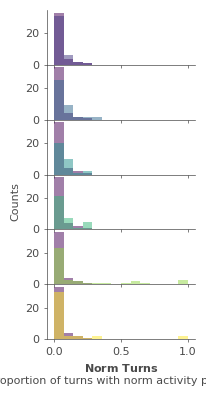

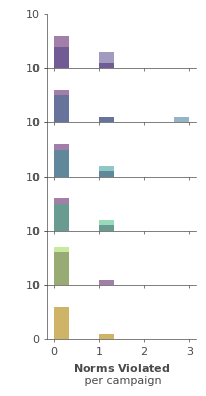

In [17]:
# === LLM NORMS ANALYSIS ===
# Note: This metric makes API calls and may take time/cost money

norms_results = metrics.analyze_norms(dfs, force_refresh=FORCE_REFRESH)

# Aggregate norms metrics by category
norm_turns_agg, _ = pu.aggregate_metric(norms_results, campaign_names, categories, CATEGORY_ORDER, 'norm_proportion')
norm_episodes_agg, _ = pu.aggregate_metric(norms_results, campaign_names, categories, CATEGORY_ORDER, 'total_violated')

# Norm turns per chunk comparison
pu.plot_comparison_histograms(
    norm_turns_agg,
    bins=15,
    log_bins=False,
    xlabel=r'$\mathbf{Norm\ Turns}$' + '\n proportion of turns with norm activity per chunk',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_norm_turns.pdf', transparent=True)

# Norm episodes per chunk comparison
pu.plot_comparison_histograms(
    norm_episodes_agg,
    bins=10,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Norms\ Violated}$' + '\n per campaign',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_norm_episodes.pdf', transparent=True)

In [21]:
norms_results['1262-firedeath-must-die-closed-play-by-post-open-ogg'].metadata['episodes']

[{'start_turn': 23,
  'end_turn': 23,
  'description': 'Using "OOG" to denote out-of-game talk.',
  'episode_description': 'The DM explicitly states the use of "OGG" to denote out-of-game talk.',
  'participants': ['Dungeon Master', 'Rylei Dreemurr'],
  'episode_type': 'establishing',
  'is_explicit': True,
  'norm_id': 'norm_1',
  'turn_count': 1,
  'episode_text': "Turn 23 - Dungeon Master: Good question. I am an experienced DM, but this will be my first time running a game (or even really playing one if you don't count the one I just started yesterday) on a forum. Just say OGG if it is out of game talk...and of course if you have something private you want to keep away from the rest of the group you could always message me. If the OGG becomes a hassle, then we can most definitely start another thread. But let us try this way first. :)"},
 {'start_turn': 62,
  'end_turn': 62,
  'description': 'Protecting the character with the map.',
  'episode_description': "Brachos hears Argo's cal

# Full Human Dataset Analysis

Analysis of all ~985 human campaigns from the dataset to establish comprehensive baseline patterns.

In [13]:
# === LOAD ALL HUMAN CAMPAIGNS ===

dfs_all_human = dl.load_campaigns(
    'human',
    messages_per_session=MESSAGES_PER_SESSION
)

print(f"Loaded {len(dfs_all_human)} human campaigns")

Loading 985 campaigns from /Users/annie/Code/Repositories/dnd-dynamics/data/corrected-human-games


Loading campaigns: 100%|██████████| 985/985 [02:54<00:00,  5.65it/s]

Loaded 984 campaigns (949,460 messages)
Loaded 984 human campaigns


In [14]:
# === CALCULATE METRICS FOR ALL HUMAN CAMPAIGNS ===

metrics_human_all = ['basic', 'semantic', 'jaccard']

all_metrics_all_human = metrics.analyze_all(dfs_all_human, metrics=metrics_human_all, force_refresh=FORCE_REFRESH)

basic_metrics_all_human = all_metrics_all_human['basic']
semantic_metrics_all_human = all_metrics_all_human['semantic']
jaccard_metrics_all_human = all_metrics_all_human['jaccard']
#dsi_metrics_all_human = all_metrics_all_human['dsi']

📁 Loaded 7 cached basic metrics results


Analyzing campaigns: 100%|██████████| 977/977 [00:03<00:00, 277.02it/s]


💾 Saved 977 basic metrics results to cache
📁 Loaded 7 cached semantic results


Analyzing semantic:   0%|          | 0/977 [00:00<?, ?it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fe5c2e5055bf14dbd532f70cd96be983.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e61a8a1b5429c030125fc145c548b3fb.pkl


Analyzing semantic:   0%|          | 2/977 [00:00<02:51,  5.68it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5b000489c0a6f30484edd81c8a913019.pkl


Analyzing semantic:   0%|          | 3/977 [00:00<03:09,  5.14it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_972d283d00887c938ca218b62f3c1255.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4e262c3c93148b9425cd987f2080b514.pkl


Analyzing semantic:   1%|          | 6/977 [00:01<03:25,  4.74it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f2575649b6d74156a77ba29f02c70627.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3709560befc4347bcf8555d5581523f7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9d42752dc7e4b35a957c24c5ba487dc8.pkl


Analyzing semantic:   1%|          | 12/977 [00:01<01:22, 11.66it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e4a93bbbddd93d35079ee92443cfdbaf.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d3bbcb814283f065c6ccd49084b2d0dc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_339de4aab1fc52f124ad0efd9f73e74a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2f6fb9e86e4564a63e45df7456e42a87.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7c6ec0bc6f0786d8917a2f8cb15b57cd.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a0b67b3116a01e0c35d636f1c0606aa3.pkl


Analyzing semantic:   2%|▏         | 16/977 [00:01<01:16, 12.52it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c30dfcb1691220d014970ce1b293a918.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4b12d422ec53adba215a878921b76cc7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cc36952d9d6ad54210be7a3488c5d449.pkl


Analyzing semantic:   2%|▏         | 18/977 [00:03<05:16,  3.03it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ff7bb519f64927a3752a82b45e19e571.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f06c5cd053a51f9efdd7089a40112d4c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0aa4568886f660ac746c69b347af3762.pkl


Analyzing semantic:   2%|▏         | 22/977 [00:04<03:18,  4.80it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3d0bc4d57988e21fefab7c63e6aaa43e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_94f24df2671b36a72f97060fb9f2aed2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_28327747f109402e1c5bcb4e22122d26.pkl


Analyzing semantic:   2%|▏         | 24/977 [00:04<02:51,  5.56it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_53c96caf8d2203a6587e05743cb50012.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6804d8a37027b63cb3c5f4e3402a6cd7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_10848457e4821630eeb62c668d16da06.pkl


Analyzing semantic:   3%|▎         | 28/977 [00:04<02:11,  7.24it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e23cb1807778ee54098a46315a8469a0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cbcb076b00a6f6fc0168276d6cfedd04.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a2f53f888aa348d73ead9f392aa3b5ce.pkl


Analyzing semantic:   3%|▎         | 31/977 [00:05<02:37,  5.99it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ff78390b8ce94f1048bb1c896f490852.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6298c9c9d3930b71fd624826a0874dea.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e99cbd3d5acfb1a353c37f47cc9f6ea7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_de67f9dfcf1bab9c3f564c2e53c89dee.pkl


Analyzing semantic:   3%|▎         | 33/977 [00:05<02:23,  6.57it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_efb0b3eeb621232befe37b9f3bee3610.pkl


Analyzing semantic:   3%|▎         | 34/977 [00:06<04:12,  3.74it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4dc569471dba69864e90eeec140e56c6.pkl


Analyzing semantic:   4%|▎         | 36/977 [00:06<04:10,  3.76it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4d07837922cc6a6b4eb5b44852e845f5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e2aeabe70ab0af5b0c0f3f53f0a8299f.pkl


Analyzing semantic:   4%|▍         | 38/977 [00:07<03:23,  4.60it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b313fadbcddb928b1435692cb4770603.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1281c0e096da6a2934b94d658bb7a8be.pkl


Analyzing semantic:   4%|▍         | 40/977 [00:07<02:34,  6.08it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_56218c355edf48e1c795669a37e2a6ad.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_79ccd593aa6b3c0c6693b374b46b2735.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1dc4655232e9568ad2bcfe0ff299c8f2.pkl


Analyzing semantic:   5%|▍         | 45/977 [00:08<02:00,  7.75it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4048eb2fc2d50aeb25cf52f51b1a6fd4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_866fdc6374ad55fad63bedd7fdaeaafe.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fd50246a30cee599dcee92747a3c5630.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_081dd937c24b1b1051e36aff1a313edc.pkl


Analyzing semantic:   5%|▌         | 49/977 [00:08<01:31, 10.14it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_91dd4c887d9bec895c1710caef832168.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_de66a30debc9f82c839f16cf3836c589.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0956e3dac6495d4caa31c1667f443cdf.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4b5d10c6ab5ec6f0d518a9bbfbaddc7b.pkl


Analyzing semantic:   5%|▌         | 51/977 [00:08<01:33,  9.95it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_515071388a218d659f87c59b07deebc7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_38ef17c11c368115836052ff395ac6e8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2e88b2abdc2104190b010becc4f569b9.pkl


Analyzing semantic:   5%|▌         | 53/977 [00:08<01:24, 11.00it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4724acf2840043e5d4da31e95b2bd239.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_061adce3c5499cb0b9e05c6302ab05a6.pkl


Analyzing semantic:   6%|▌         | 57/977 [00:09<01:24, 10.90it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2a3276c314a530ded123c762bedce41a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4e5dc1a3fca81fe14ae49a55d691e625.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_29c8121f1c7a944afa584fe3ef985053.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_27a108729978e8949fc99e47ad48d85b.pkl


Analyzing semantic:   6%|▌         | 59/977 [00:09<01:28, 10.37it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f37c5acb237a26626d656570543c95d1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cc57a6fee954889070ab3634ec7f2c2b.pkl


Analyzing semantic:   6%|▌         | 61/977 [00:10<02:43,  5.59it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0ac133dad4625f4b298460da60661f15.pkl


Analyzing semantic:   6%|▋         | 63/977 [00:10<03:08,  4.86it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dcdbc37ff2d6819c2adacb9b86668af2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c4f68f257030df6e45b0b1a303a28275.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c7750c278c6619177f15dfc8d1b85bfc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b77138151314997fbfde9105b319568f.pkl


Analyzing semantic:   7%|▋         | 66/977 [00:11<02:59,  5.08it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ffaf840b8e3cea0222b41fad80a59bbc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c794f9cecb94b658de3fd8f61c78f087.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4215713f09eae960e3a8644a1901cccb.pkl


Analyzing semantic:   7%|▋         | 71/977 [00:11<01:57,  7.73it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_081a40f9ca2f06f3d63fd26f32ed8ecb.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d5709a4909add96a6a03b2409c790feb.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7e32dc7d418074ef8fb6ec274a8cad80.pkl


Analyzing semantic:   7%|▋         | 73/977 [00:11<02:02,  7.38it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_603794d29658d914eff5b20fa46cf450.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_717c115f872da22d51d851f92759944e.pkl


Analyzing semantic:   8%|▊         | 74/977 [00:12<02:25,  6.22it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_17921231c56be06a4906a1313ab0a12e.pkl


Analyzing semantic:   8%|▊         | 77/977 [00:12<01:56,  7.76it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_952e5a9746ab7578f1b333942e3bc96f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9d5f2aa998e3060338e8024f139c159c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9c1090455e173bb8daacf12e547f91ef.pkl


Analyzing semantic:   8%|▊         | 80/977 [00:12<01:38,  9.09it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e5dfc24197147d7e6929722fcd45b91b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8adc95d128622f5ac6b08f1b9c5f2ab5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_078ec7dd56bb06aae2c8cca76f56d90c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3908cf99b5c94f53d04bcec3fdacb57d.pkl


Analyzing semantic:   8%|▊         | 82/977 [00:13<02:04,  7.22it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e3f528fd1608c737949cb9bf4395481a.pkl


Analyzing semantic:   9%|▉         | 86/977 [00:13<01:49,  8.13it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f460b82b649f83d68cd1a47600f7436f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7f8e4fcad6656d55dce46e8950d180d6.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_15ca3e317f96ea17027a67885be1fc52.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_937a62bd7bbfd2209e27736e6e5349a9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_db9402185755a20172c308ae0a8d6a17.pkl


Analyzing semantic:   9%|▉         | 88/977 [00:14<02:21,  6.26it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3a941f798e8ec5475581d8341f33bb1f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cb5a4447b644e6c48c84605c8cfa6721.pkl


Analyzing semantic:   9%|▉         | 92/977 [00:14<01:50,  8.01it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dafca5a907f65273485d2f654ab67aa5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_39e196425be26a9598d358bab1c90f85.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a892d4a0bc602d5c734257865b73b7d0.pkl


Analyzing semantic:  10%|▉         | 94/977 [00:14<01:43,  8.53it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_309b83dfa702f08316eea06518436138.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9cec80a9d7af26ea9845255c49a63889.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d50ea1e568e8fd535610c42969776627.pkl


Analyzing semantic:  10%|▉         | 97/977 [00:16<03:33,  4.11it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2a355cbf9d39e37bfd2a794f992a82a0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_37ea194d79852520b7a85d5f21f341d6.pkl


Analyzing semantic:  10%|█         | 99/977 [00:16<02:50,  5.15it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_704f3afb7a49c0f1c1c18960345251fc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_54d727af06f13c8b6a31c082002ec474.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c6f7eee6349e6078a22ecb9ef0b6d1d6.pkl


Analyzing semantic:  10%|█         | 101/977 [00:16<02:12,  6.62it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ec82c8d80925d1b8890e11aecc6697f2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_38fb64e971d894c9a011b9586cbd800e.pkl


Analyzing semantic:  11%|█         | 104/977 [00:16<02:06,  6.91it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_35c58ce6b77b41db14f73d2b1460a930.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2fc57ba825c864b93744f3666b1c788f.pkl


Analyzing semantic:  11%|█         | 108/977 [00:17<01:53,  7.63it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_07c1cb46c85447eb48bdac3469574764.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_592e1c5ec112ef3349daed18607c86f3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_86f93cdfca42394c73d2a4ea5cbfc5d0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5bf1f8f326d72f06471a5771cc197c3c.pkl


Analyzing semantic:  11%|█▏        | 110/977 [00:17<01:37,  8.93it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7f850b0a94e69ecbaa273a20c3d19af0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8eee07df25c05f80542ca9817b26f5f4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2284eb2f65b6ff436ad72f733a24a2de.pkl


Analyzing semantic:  12%|█▏        | 114/977 [00:17<01:30,  9.55it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4cb4fc332c652447a970a73a31a304dc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_99676541a5cc38ba765b9bead246f46b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5f41f263e0d2365300bd576d98f4b469.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_66f9c18bdfacafc0c0657f4386689a73.pkl


Analyzing semantic:  12%|█▏        | 118/977 [00:18<01:59,  7.20it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f56e67eaa96fed36cd8a3bcd3fddd62c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_46eb49ec417c7f7ba68fec8bdeb0fe2a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c4e056845d9a7a611e810002d590002d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_04f7e100654236c34d4948af68cfdce2.pkl


Analyzing semantic:  12%|█▏        | 120/977 [00:18<01:38,  8.74it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_26dd75c90678cc05845cbf1edf398b25.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5a40c1b371e94b51342bf700c3f10abc.pkl


Analyzing semantic:  13%|█▎        | 125/977 [00:19<01:24, 10.12it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_52f856b89e0897c1fb97fef36b3bc484.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2b586d55860f47bee5e90beb985c68f6.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_217290a88d833efcd2b38493818e4241.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b474c1fa11fae18a730643d0b49a4bd5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e2cc37f753b0fe6172a1c0411aad5314.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_431b7e4c2230f0e6cc90c56b17d4d9e2.pkl


Analyzing semantic:  13%|█▎        | 130/977 [00:19<01:24, 10.07it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a1d8a208ca4013d4866f6b268e0309ab.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ea169adef6570ed9da081cd195c823fa.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_07ebe9f7b483ffc4b81f946421c5f2d2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1d492313710cf28944234ee807fac341.pkl


Analyzing semantic:  14%|█▎        | 132/977 [00:20<01:59,  7.04it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e8b01cf5f4a24f517d8281c224992f1e.pkl


Analyzing semantic:  14%|█▎        | 134/977 [00:20<02:27,  5.72it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5c9ebe05dd85fa4e058190956091b65e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7c1ed430d7dacd2f7d49c97ce7f76a49.pkl


Analyzing semantic:  14%|█▍        | 136/977 [00:21<02:27,  5.72it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0ede45d64bf330c3dfcbd4f19d3c7196.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8726872140ae5b63312b5be6d7cd6b69.pkl


Analyzing semantic:  14%|█▍        | 138/977 [00:21<02:04,  6.75it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b62a49fb3e53ff4dde96e8775af80f57.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7a331ed753395d49b9f6d6c1ced77d4e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_14fe95f84616630222e8a07f80820de3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4c3fed5d88be9809345143c5d19b6112.pkl


Analyzing semantic:  15%|█▍        | 144/977 [00:21<01:05, 12.70it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c8bf82f3a99d9f395e61bd90b71e9669.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_56512c7a5111935944c0c08724138085.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fb3c0fd571fb66c15f2aa443ef454220.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cb3fd9b1767b93bad88891b2f87579fe.pkl


Analyzing semantic:  15%|█▍        | 146/977 [00:22<01:48,  7.65it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ee39558488cc5cb09cfb8271f0717b70.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1299a5f7c12f2d17977e0e2c31caab6e.pkl


Analyzing semantic:  15%|█▌        | 149/977 [00:22<01:20, 10.29it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6e40df3b111ef61f56fb2e90719f13b9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_86f8ab3ee0a6ac77b0fe74cd00afc0d6.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8b965bf9e3ea7f4979a971ad23208724.pkl


Analyzing semantic:  16%|█▌        | 153/977 [00:22<01:16, 10.78it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5bf308f6d4c003abc6a8a876ee4399cb.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_18356b0ba47d282b9be94d8fd625e45e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8af1541a3411952be4316ea298eb7f87.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d9da4e9f26ab011a273fd413068b1a09.pkl


Analyzing semantic:  16%|█▌        | 155/977 [00:22<01:14, 11.06it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_af764f6bb6b465a4c1292e16a20f2044.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ed3e8686648caa29f3bb3cf1eb980db3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b8edde1e858633ee1295e6d8a77dfbc3.pkl


Analyzing semantic:  16%|█▋        | 159/977 [00:23<01:09, 11.81it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b7398c641a62015a113a33b30a142763.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_021117d9f21b1c651a4af0abdbe9ce37.pkl


Analyzing semantic:  16%|█▋        | 161/977 [00:23<01:13, 11.15it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_28b6c3418f6ad219e09f73ac887ed850.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7542855775342de8a9611706d3de30bb.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0eb2b715321a9b60e5ecf1da603ab7fb.pkl


Analyzing semantic:  17%|█▋        | 163/977 [00:23<01:09, 11.75it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fdc2e3a9ba32abaddc90e01f266516af.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d2c9e4ad4a5e0ffe3d0925c670e58936.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cd3ab65731024d34d720ffa5f33b0195.pkl


Analyzing semantic:  17%|█▋        | 165/977 [00:23<01:07, 11.99it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b4674a8e8e71944765c7a3b42f0b8752.pkl


Analyzing semantic:  17%|█▋        | 169/977 [00:24<01:35,  8.44it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7ece36aa82af093521837d801ace6d05.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_066a025f6a739f481ccaef2dccbaeba9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_70458cc1e98994ad5227bfe252fcdb1a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_38caee083e9d56d674799d1c128c6433.pkl


Analyzing semantic:  18%|█▊        | 172/977 [00:24<01:14, 10.74it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9ab24be61a51c99d94983d020b702220.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cd442e5519287965325b30f211c2e8f4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b81c338b916dda0cf816764599454b8e.pkl


Analyzing semantic:  18%|█▊        | 174/977 [00:24<01:13, 10.95it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_31e6397b9c058a1552f40b694e498179.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c3dddec43194b70efa5035aa749f2978.pkl


Analyzing semantic:  18%|█▊        | 176/977 [00:25<01:32,  8.67it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_02a785e855bba43ed4da659e9eedd619.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_04087b7e7a7e72fd48c3ba74bebbf8c7.pkl


Analyzing semantic:  18%|█▊        | 180/977 [00:25<01:38,  8.08it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a1d97bfc814178f4bc4e033bd93d8aab.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6d97f3ae686d2df0b30551b7c833334f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b301e83f1d1a2051994f85d0843e5733.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e12bc0ccfc91c3b87375133dada7e6be.pkl


Analyzing semantic:  19%|█▊        | 182/977 [00:26<01:54,  6.92it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9a54aa5022293a9779b8ca887c0f1a57.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_771c0a8aa2840af2d92c105b650df0b4.pkl


Analyzing semantic:  19%|█▉        | 184/977 [00:26<01:34,  8.38it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_202d7389816536a2027d6636dd0066df.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ad8ae490808e8a0ba3c0d7afd38d6727.pkl


Analyzing semantic:  19%|█▉        | 186/977 [00:26<02:00,  6.59it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d6694da0f64dc642fb436d5c374282c1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6bf623579d3c17345f223675dae47251.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ce843302faf636d71cca1ea250a1cc30.pkl


Analyzing semantic:  19%|█▉        | 188/977 [00:26<01:39,  7.96it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_51da1e3d4fabd2c75141ca93361aafd4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7c7e5ea4bbbbd1113b536aabc6c34504.pkl


Analyzing semantic:  20%|█▉        | 193/977 [00:27<01:45,  7.46it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a8dc9d195f27a1fe9bbe7a5281cebace.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fa59aeb7327ffebbda9993172e4fd14f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4233dab3174ed04fee0a17a240b33b83.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0cafe618db0fe37e6781da51a8d9a0bb.pkl


Analyzing semantic:  20%|█▉        | 195/977 [00:27<01:46,  7.32it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3e219391d78778bf0f7d559d603d74be.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b8a77db632bbe34b5c705e549add9256.pkl


Analyzing semantic:  20%|██        | 197/977 [00:28<02:09,  6.04it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_df05e43a64a4c62c4ba14d46d0bf620b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_66173e5bd49f4044b0067d0aa295b1b0.pkl


Analyzing semantic:  20%|██        | 199/977 [00:28<02:13,  5.81it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b004390dc282d1aa8ff9fd73320f220f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b885cc779ce3f120374aa65e33e32d1a.pkl


Analyzing semantic:  21%|██        | 204/977 [00:29<01:13, 10.57it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_66a5345374cb2792b518c1506d47f90b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_aa60bc744e87ff9955cd1a3052b2b4c1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b63a51a9cbcf1d9a047b53ea2f8aa496.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e68ffc429ba85dbeb690b380fe069318.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b8915fdb775f3e672ce56d8f01a36b8f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ce55c07469ecdffffc513f9754c8e255.pkl


Analyzing semantic:  21%|██        | 206/977 [00:29<01:38,  7.87it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2194f7c0dcffb703735ab8fe2d111145.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8d015b1d6dc283491c4ee1dfabcd66f9.pkl


Analyzing semantic:  21%|██▏       | 210/977 [00:30<01:57,  6.52it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_167b101df9780e6afb731dfb077e5baa.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_469f08733d5f7b3929358ea2cbbabaa2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_31108d38fab61aab62a4d4e1ea33c209.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9b42479eeee50ecb8145db4460b0da25.pkl


Analyzing semantic:  22%|██▏       | 213/977 [00:30<02:10,  5.84it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_253f72abcea77902cb408d995063496d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ff4e9ba30308373ed15670670e402be2.pkl


Analyzing semantic:  22%|██▏       | 215/977 [00:30<01:42,  7.47it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fb025cb34079af5fece3129ab2639740.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_41f268c0eec9680a02ba62d7c1fd1f43.pkl


Analyzing semantic:  22%|██▏       | 219/977 [00:31<01:28,  8.55it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_25d587c1107f7f5ac411dd8ce8f7e514.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_02447f9c6616a8410a12c0b0a822fef7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1bfb22816514e28faab20d665d75fbd3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d6001f10a0cd9f5888232a4767ced3af.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b9b00f2bc340da6a6962a6ff17c37b79.pkl


Analyzing semantic:  23%|██▎       | 221/977 [00:31<01:14, 10.17it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5c886d777c06a80372a58031996ee9c8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_bf710a9ee99cb4c84db6885bac0a5ad0.pkl


Analyzing semantic:  23%|██▎       | 223/977 [00:32<02:06,  5.95it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_519eebb3747686a1af9676f303a0a157.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_70f7744d05eb7f34def047476def4319.pkl


Analyzing semantic:  23%|██▎       | 228/977 [00:32<01:24,  8.85it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7aa5170e75ca044fa63f33450a064f21.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d56d1932c918fa223907a1cb847ee7cf.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c8bb3fffc02dc91871b56483c04b8b40.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5b7f1cdb69172d3c9b931df231b57746.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_00ef7edfe04af92c2f7d2d826050634b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a2491253c1586633a7c4b6b66e02fb74.pkl


Analyzing semantic:  24%|██▍       | 233/977 [00:32<01:05, 11.41it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ef7ee39185ae349079bf1465f650d774.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_59bc4c44472d4c82270fa45aad2ad56e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ea4de79545967c73306d3a475471971b.pkl


Analyzing semantic:  24%|██▍       | 235/977 [00:33<01:17,  9.61it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3f09bb166975bb838c5c05fee27a4188.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_baf0129977a622a518f4480e0e497f43.pkl


Analyzing semantic:  24%|██▍       | 237/977 [00:33<01:50,  6.67it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_57987a815f21fac6775e97956fa41629.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fc7df6dd50beb043ac1a72aaa570634c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d48478c98e554375b020dbe3a06ca10d.pkl


Analyzing semantic:  25%|██▍       | 241/977 [00:34<01:36,  7.60it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a05f47a09a6ad1f686be7418abcd8047.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2d8dfb358c7be50c8f048f28e51a95cb.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5489ba1ccf177826386c23538a41e122.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0b36fe14ddd041d5aa941a100f31e091.pkl


Analyzing semantic:  25%|██▌       | 246/977 [00:35<01:46,  6.85it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_333208eb31b105c93739316309f7fed9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b3c613d619f4369871990b7c74406cbd.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5ef63884d9e0353f2a3877deb8a2ccbf.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1fef892213d3ec1f235f33bc67a96e64.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d2030cb45c65e705667e40cbac72f3d8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4c92cb554bf4dfb94468a3bb49403e31.pkl


Analyzing semantic:  25%|██▌       | 249/977 [00:35<02:13,  5.46it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dbaef4c2617feea6809246731f1222c8.pkl


Analyzing semantic:  26%|██▌       | 253/977 [00:36<01:59,  6.05it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a4ba5c98b1379ca818208c41b0881dcf.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a12318a2cbfca7da950dbc418778b465.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f506f99730176a4942afdbf4ddcb804e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f6a4f6868476b1e46720442c16f22845.pkl


Analyzing semantic:  26%|██▌       | 255/977 [00:36<01:36,  7.46it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cf7cd6e5af2f9d10e11e952dbaf53f9a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_38c3b0d3b142414be12ab600db350086.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_695291b31b7e0d32ce26e3873a7d51c7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_29d4b9bb31ecb8f71c4bc87dfc2912b6.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_15cdbcd8224519cb01df26cd0afb0dd5.pkl


Analyzing semantic:  27%|██▋       | 259/977 [00:36<01:09, 10.38it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8e275dffdf314c6c60a3866e124494fc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5c09f2330de4a4875fa5f960ad233c5b.pkl


Analyzing semantic:  27%|██▋       | 264/977 [00:37<01:13,  9.67it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4178b68cc41aed4bf58f2a89cdd1f674.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b8f0d1d1d41d4fb809c9c0cae9ea497a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0600a39e3cba553764ed6ac59817bf34.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_23b01ccec238e5c7915ebabe17cdf612.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1a00ed06608ca279604c23c28c0237d2.pkl


Analyzing semantic:  27%|██▋       | 266/977 [00:38<01:45,  6.72it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_efc92f306d063d63453dca29d111dad8.pkl


Analyzing semantic:  27%|██▋       | 268/977 [00:38<01:42,  6.94it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_de9096af4dfa78d465d2b889fe3d2cd0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1b225bff8368249499cf50fd8c93766b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_826551e76c02d1a18d5862fd632e3c1a.pkl


Analyzing semantic:  28%|██▊       | 270/977 [00:38<01:32,  7.67it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_083fb17530f1c10ed8a99bbc375a06b8.pkl


Analyzing semantic:  28%|██▊       | 272/977 [00:39<02:08,  5.50it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_55e90502c255174bc091f872e72b9f66.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_92a0d19ec46bfe96f9a3e7323acf5d11.pkl


Analyzing semantic:  28%|██▊       | 277/977 [00:39<01:27,  8.03it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b885762342f82aa4beaab97f6c209a7a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_431136c4f656bf9578a73cd6a6b36c9e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8120b412a48d67816a79c6a0c8bd9011.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8a86f62c1276b889a8b3b50309a4a7c8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e3addf97aaacc7cf2de80d4ebe7ea59a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1e23b27eacf603cf1cf6f5c59f8b1f10.pkl


Analyzing semantic:  29%|██▉       | 281/977 [00:39<01:02, 11.15it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_01c3bcad2407bdeef05ffb1dd9e01ec9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_bfc214cfc733ca4833175bac87805209.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d282bd221da2f6f490594ead299bf315.pkl


Analyzing semantic:  29%|██▉       | 283/977 [00:40<01:15,  9.15it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b72d3c6c0fe98ae5311c011b11e61e9e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_03bb72d9b74e42e659a969609a0d2092.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_549853b28b50fb2a6f9a6b77e61785f5.pkl


Analyzing semantic:  29%|██▉       | 286/977 [00:40<01:39,  6.94it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7cffbc65e12001ec4d7950f60ffff4c4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d96dc37219f1a5bfa44916047c72d436.pkl


Analyzing semantic:  30%|██▉       | 289/977 [00:41<01:39,  6.92it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_41a8a87842ccb3c4cf889294d46509f0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2a984ce9f4fe67c2f00faad73de41558.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8e4736c2a9137a2d6d9e1485562dec4c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_26d397703c07ee3c9da0735c7b7f2baf.pkl


Analyzing semantic:  30%|███       | 294/977 [00:42<02:10,  5.23it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_54a98df46408b60a3f34ecb5c5aa69da.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_edc943f1a41554bd794bb7479424d56a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b0cc8f958e4f65eccb430239a1dd3b08.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f3853fc0a2380a0d74807d834ab77603.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9c57d6049122c0b1347f303508fafea7.pkl


Analyzing semantic:  30%|███       | 296/977 [00:42<01:50,  6.16it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3318ac63c0dcd1e9a9bed41dfa8f09d6.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_052803f229726a039c2f9823b20f0f97.pkl


Analyzing semantic:  31%|███       | 298/977 [00:44<04:32,  2.49it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f35c92a48cef1722c163950eca6bf1a7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3f35fca70dc3c3897d3b12363f20c2f7.pkl


Analyzing semantic:  31%|███       | 300/977 [00:45<03:53,  2.90it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d6839c1483c758ffb178e8642d715354.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e71155ac363f69e7c6aeb700400dafca.pkl


Analyzing semantic:  31%|███       | 302/977 [00:45<03:09,  3.55it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2f3dfb40b99a728ac19e5d19a81a34b9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_eb9f3d8c5fc5503ea362f38b9dd789fb.pkl


Analyzing semantic:  31%|███       | 304/977 [00:45<02:34,  4.36it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_559752b234b9f037d2674c08ec0bd015.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_998483af99ee19c4932d2facea569c78.pkl


Analyzing semantic:  31%|███▏      | 307/977 [00:46<02:08,  5.21it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dfc8a759a5dea3bfb7795be53bbfee05.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2ea84ff95cecb0e1d4bacdd06ae7964c.pkl


Analyzing semantic:  32%|███▏      | 310/977 [00:46<01:31,  7.31it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3fbcf3ea427eb98e5227884b5dbd7a9a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_630601f17aba25c9511dcbead8a64597.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1507af83b4032c0b73c232716f2cbbf2.pkl


Analyzing semantic:  32%|███▏      | 314/977 [00:46<01:02, 10.63it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_090a4d871e75881a9db86ae1c4691b11.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ef15b87605dd6d298cedb87e6c3403ab.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_25dd49ffddb3b86ae9910d1699bfd466.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_66e742064282b6c5d0410e5435458a0d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0e4053efd00c407533901151e32a6853.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3483317ce64b6f4221e374ac446a1180.pkl


Analyzing semantic:  33%|███▎      | 320/977 [00:47<00:54, 12.11it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f6dcb087660b6e6851e0fdb4a777aa12.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0b926d3e21eb400056a65699025d628e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d83cf2c98075fa2d30f05124824def7a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f4bc44b6053ca0ce369bab5a3be3efc6.pkl


Analyzing semantic:  33%|███▎      | 322/977 [00:47<01:08,  9.62it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8d68d280ba8cc9f6addbf311a8ea0579.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1764ab611c4a9ad6bbffeea2b0effe07.pkl


Analyzing semantic:  33%|███▎      | 325/977 [00:47<00:52, 12.50it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_79c606ca12a5b3f967c265d21f60c4cd.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_20ef6cc9e65647d6b2d29ac7fe8b30a1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ea4a9743d6f2f27bbb983bb6ecd9229c.pkl


Analyzing semantic:  33%|███▎      | 327/977 [00:47<01:09,  9.41it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5e6327a297a49dbb78138eb8eeec8545.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_763590027c01058a20baf6f30b9ea553.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d504538867f8e3d19d7f57ed171085da.pkl


Analyzing semantic:  34%|███▍      | 330/977 [00:48<01:01, 10.54it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2460314d60b1179d581478d1d9067f5d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_92154a41c7856496658e3bcb8530dd0a.pkl


Analyzing semantic:  34%|███▍      | 334/977 [00:49<02:13,  4.83it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_38884ec2b78887faef2ec2c92ba37c32.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e44fce6a33fd144fe414c23adbc55a2f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9a39b1ce72f9d00a5df63067af9ee304.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_40e1fd2b7ff57bc3f2f934ff07a6efde.pkl


Analyzing semantic:  34%|███▍      | 336/977 [00:49<01:47,  5.94it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_331313bcfc89e18610a32601c1eb28b8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f0915cf2ad398c971479647d7f968899.pkl


Analyzing semantic:  35%|███▍      | 338/977 [00:50<02:15,  4.71it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_75cf7dba60312d21142afccaa6dafe3a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a9eee1fbae8d77542047df854fda0ed7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_38889b49984f0c6ae779630f41e02844.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7eaf681dcb2ca61481b6211f8ec060e4.pkl


Analyzing semantic:  35%|███▍      | 341/977 [00:50<01:35,  6.69it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_bfefe4ff10d192a7b3cf2e2c28019393.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_446d4ad8a581fbab680a017a98c1951c.pkl


Analyzing semantic:  35%|███▌      | 343/977 [00:50<01:28,  7.15it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f49e0f1626f44a93a9651476bdaba624.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1fce33149b14354e96c4ae50da8a155f.pkl


Analyzing semantic:  35%|███▌      | 345/977 [00:51<01:37,  6.49it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5d1e9b3545d68e76e520004661a0c4d1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f15440582d920f90edb8482584722dc7.pkl


Analyzing semantic:  36%|███▌      | 348/977 [00:51<01:43,  6.08it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_91faf8ef317ec0c78c2295e9cad61505.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b9bfa386d1bdb5774b502e083d0f388e.pkl


Analyzing semantic:  36%|███▌      | 349/977 [00:51<01:38,  6.35it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_358d3fb197b9a0fd051f3a57bb134e08.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_69c4f7dc528d9855266dd22934e3f90e.pkl


Analyzing semantic:  36%|███▌      | 353/977 [00:52<01:20,  7.76it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8f6ee6c639228bd1d8d994e6f6f6adbf.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0c3a52e81bc77d220f5a3712bc4c3e03.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_af69154762d0731a8e778ebaf9f732d0.pkl


Analyzing semantic:  36%|███▋      | 356/977 [00:52<01:12,  8.59it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cac44bf74f709a51bae0326a8ffcf5a4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d0185f2fc112954bbcb87c9ab80ca559.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_21545fd01fc16f3ea8a34b20317a7176.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e9060d6fa4e3e273c0827db1103ba1c9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7d638390ef5bb8313983d00ee63f6dd3.pkl


Analyzing semantic:  37%|███▋      | 359/977 [00:52<01:08,  9.03it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ce0fdb4b458ade48f2396db2012b1d63.pkl


Analyzing semantic:  37%|███▋      | 362/977 [00:53<01:05,  9.43it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_db8a3ab9e9b0f116ab7ec433dff25270.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5c889dbea0451b0d0dba1eccb3156ac8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f466779f466938f8d4e574db762dab01.pkl


Analyzing semantic:  37%|███▋      | 364/977 [00:53<00:59, 10.28it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4886773067c5388aeb553136c2874d84.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2019ce1e2d82bc4c87ce05e6e93177ab.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_eb5931fb913bfe5a70e38db87089f067.pkl


Analyzing semantic:  38%|███▊      | 368/977 [00:53<00:59, 10.24it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_09980bd9b30ced514bf03fc1d3d0d62c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ce978058525eeae3d8e4e2313b1608e7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cfbbd40c2b988ac1ece4f1db88be5768.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1d98ba29013c09524739d75e2ca42d5e.pkl


Analyzing semantic:  38%|███▊      | 371/977 [00:56<03:21,  3.01it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_aac53602d29fe8fe768c61067db48720.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_847182fcdd5db598b83043b982e05a87.pkl


Analyzing semantic:  38%|███▊      | 373/977 [00:56<02:29,  4.03it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9584582a0c1070f3adde923f171dac17.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b6a224daa7484fd7655aa282d2188d27.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dfe2b885ba6c0ee5836cad419da99ee6.pkl


Analyzing semantic:  38%|███▊      | 375/977 [00:56<02:48,  3.57it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2bab7056c0f12aae2e156319b5439d0e.pkl


Analyzing semantic:  39%|███▊      | 377/977 [00:57<03:07,  3.20it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ebaf0fd6c9b3a9fab6322641170944c7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_631cceec4ef5b6adcb59254db2826a58.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3735eab9c65ee57e3250dbaac3fbf8f4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_272485762867fd40563e72d5213529a5.pkl


Analyzing semantic:  39%|███▉      | 383/977 [00:58<01:20,  7.41it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2e3a6f82c058a8c14e8e41480f95c9fd.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9e02a6c9d5368b178956ffb3a69bada5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e600b173face01cb6cbbd14a5bf38f59.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d8ed4744d6887fff7bbb1c19542ba890.pkl


Analyzing semantic:  39%|███▉      | 385/977 [00:58<01:10,  8.34it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8dbc05d4b565bb4a09bd07c2a72469d1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_542d0a7b394c17ff79f7f7806b373bf0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c704b3bad38d5ddc8f779f57e9b7a992.pkl


Analyzing semantic:  40%|███▉      | 387/977 [00:58<01:47,  5.47it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f21ed63c8669c324954019f93ec1bfb8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8aaa4813357aa578fec941f4306495ce.pkl


Analyzing semantic:  40%|████      | 391/977 [00:59<01:21,  7.18it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1ffc8d8bde765930d8799ea50a007209.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4e0889d8515f1b929f9cb80ba5cd158d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5898f6e76b08a087e4eb9bb3ae199124.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5a3dbeb7712474ac06365a7465cbb9b1.pkl


Analyzing semantic:  41%|████      | 396/977 [00:59<01:05,  8.94it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7c1ae3b72ad8b1f36002f3fb42c769ba.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_75fd3884ab81fd4841922bcc27b41bbd.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c2435a7508399879ad113f1efec59026.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f61019c8c6973bfd25f625b938d1af0e.pkl


Analyzing semantic:  41%|████      | 398/977 [01:00<01:35,  6.09it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_06a60eb163b77ef9d977ea90cf99013c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_586ff25043c98107e5123ce8ebd570aa.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_42dc845ebf2ee3c4e86dbea88df89741.pkl


Analyzing semantic:  41%|████      | 400/977 [01:00<01:31,  6.32it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3fee27159c9ae4ed1e096e2d992b8b61.pkl


Analyzing semantic:  41%|████      | 402/977 [01:01<02:24,  3.97it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_890cd2539efd2b9804c832bf3a07587d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ec25f16fcb52a1dd4cd658d9a24900fb.pkl


Analyzing semantic:  41%|████▏     | 405/977 [01:02<01:54,  5.01it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_183f07e18e50412b46381a13d4b9ac77.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_793c801e058e7995f87ac808eb3dd629.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c8df30ab3dfddf97b61e5e86e59963b8.pkl


Analyzing semantic:  42%|████▏     | 408/977 [01:02<01:26,  6.55it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a6d278c44d8e044c63c41344c69cb861.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_105a000c9630073adf954fb6a1f39ae2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_19764d5f0f40f0e62b853313e0694dc8.pkl


Analyzing semantic:  42%|████▏     | 409/977 [01:03<02:14,  4.21it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9cea7275c378d36c07baa8c6db79970c.pkl


Analyzing semantic:  42%|████▏     | 410/977 [01:03<03:13,  2.93it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3f7fac19de6b8e64396a566caf11b262.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6ef238235f4663c9748532cc7b428cfc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ce42fb355115c1a8dbf96d5c96e028be.pkl


Analyzing semantic:  42%|████▏     | 413/977 [01:04<02:06,  4.46it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_34450b342351b007118cf1b49ff28cd1.pkl


Analyzing semantic:  43%|████▎     | 416/977 [01:04<01:37,  5.76it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ced0394a5c36536dfea46e0c730eca30.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_842f2fb10730397eff74f227e5a80d20.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e16938defa1ea5da66cc247bed45a75b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cbc364d228d262afb11b218c41d66ea6.pkl


Analyzing semantic:  43%|████▎     | 419/977 [01:04<01:09,  8.07it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0b3343b2f23c2cc4086ba3fe6ee663c2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_465326caac8e5ad0be79c554c45df115.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d914cb0cdebc27e0fb625f7f0c771fd7.pkl


Analyzing semantic:  43%|████▎     | 423/977 [01:05<00:56,  9.73it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c80fa4422ea5f5829a070cfd996b7199.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_032897053b65bc8cc3ad9f894f5e2c0e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b8454c553cdeec5561dfda2916e1a613.pkl


Analyzing semantic:  44%|████▎     | 425/977 [01:05<01:12,  7.56it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e2ee2e126e1dac4d1b43a0b000cbe5cc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_74a3eabccee613e65b875a474ab4905e.pkl


Analyzing semantic:  44%|████▍     | 428/977 [01:05<01:01,  8.90it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5e0f532d2268257a843ac64b439279ce.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f126b33e72fa7b4d8221c19a2f0d996d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_93987b97eeaffe47750f4ebc075ab74c.pkl


Analyzing semantic:  44%|████▍     | 430/977 [01:06<01:15,  7.22it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_485492371abe8df8fef10475aea7f991.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c8684a52c91be4649ff843ad4b1b978f.pkl


Analyzing semantic:  44%|████▍     | 432/977 [01:06<01:10,  7.72it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7231bf18473350dbed7f9ad4707c2e5e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7fd42912e926be3912ff1f2b36e94903.pkl


Analyzing semantic:  44%|████▍     | 433/977 [01:06<01:16,  7.10it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6f6b2b4bdefd1f97a8212774b0cabdea.pkl


Analyzing semantic:  45%|████▍     | 436/977 [01:07<01:53,  4.78it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a7f82e685746464a9044d6ab064a3a26.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_be71ecb5f5fef8e7e35e8219688cb8e6.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d462a73ad1e606b7c2ffc6276eee402b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a84685f74a39fb1ee58ce0bac92892b1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b2c16f5ff909243f18814846bd1ffb60.pkl


Analyzing semantic:  45%|████▌     | 440/977 [01:07<01:03,  8.41it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0fb6d3b8780c9a742f7e8daf060b2f40.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d06bf962d6ec43178fdb115e563e824c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_800b83acf145bbb390f92233f905536b.pkl


Analyzing semantic:  46%|████▌     | 445/977 [01:07<00:43, 12.30it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e30cc401dfe103d1c72be0d6d8b07033.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c93a25a4dcea0b67f6172a190fc50394.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5182aed1c72ae65ebc479a3df2bc934e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7f168b9dcd1503680145021d4f04c06c.pkl


Analyzing semantic:  46%|████▌     | 447/977 [01:08<00:53,  9.82it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_23c160632282cb74224a327752eb8f14.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_43b9679d940b0c0aaee30fe006e79cbc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_af5f4b49a7173e09e3aaf3cb5542d2d9.pkl


Analyzing semantic:  46%|████▌     | 449/977 [01:08<00:55,  9.46it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ca5fdf28bdca2f48764e19c97a82ef90.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3f7aa814e5dadd67c50189201cff16d9.pkl


Analyzing semantic:  46%|████▋     | 452/977 [01:09<01:23,  6.32it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3db00666a28af20d3b6a532641f3f727.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_adf14039de0594470ce503df5637c0a0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ae79b535996f6fb7377bc96c67a9b1c5.pkl


Analyzing semantic:  46%|████▋     | 454/977 [01:09<01:21,  6.40it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_92d2c63e56109178df5e549a0366597d.pkl


Analyzing semantic:  47%|████▋     | 456/977 [01:09<01:21,  6.40it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_667cd0bcc3dc2d8a0add3c1bc3d1df94.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b6aa0e185ee22b0a4e945735879d22cf.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dc5788df5907b0a17259fdcdce7ba03b.pkl


Analyzing semantic:  47%|████▋     | 459/977 [01:10<01:09,  7.50it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_89f18e3f47899738cad352143dcc7b24.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3f75a2275ac71724d3cd9649f61eb607.pkl


Analyzing semantic:  47%|████▋     | 462/977 [01:10<00:57,  9.03it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_bb0b739c02d0c3c84455aef1d299afce.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_41213b19ea66f0849403dfa185d47084.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_236935abdffbec9b11528f6a76f22a2d.pkl


Analyzing semantic:  48%|████▊     | 465/977 [01:10<00:49, 10.25it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_20e3397ce1c637761133fbe73c918337.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_386a52bc5a51304948c027970f5f0742.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c4904b050043f6be4004b53a868469a0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_bc7a8ba296d59428bc6f487dd1fa3a9c.pkl


Analyzing semantic:  48%|████▊     | 467/977 [01:10<00:42, 11.99it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d25b40587c274185f0af2ce66584687c.pkl


Analyzing semantic:  48%|████▊     | 471/977 [01:11<00:48, 10.42it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a576c888745bed280f4539e26cd31f27.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e714428670a97b74ad035ab83833558c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_950465d5b94a62c3436c0bbef661bd5a.pkl


Analyzing semantic:  49%|████▊     | 474/977 [01:11<00:36, 13.80it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9b655a675f0def5d09d216b53c656628.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_106a22c87715b3136790273b526dfbb0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0b47dc936887a1193f2b912fa4c86603.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4c9305533cb75f7f0734d9b67700ef9a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9d19624531abe553caeb15c1146f908e.pkl


Analyzing semantic:  49%|████▉     | 477/977 [01:11<00:37, 13.46it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8f5e8aa5fafeeeb7f739b6f493f4e543.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3b883cb0bee9d01e926d17a9bc357f4c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_84f28449fe22cf867539c3bcf136b63b.pkl


Analyzing semantic:  49%|████▉     | 480/977 [01:11<00:30, 16.07it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_00e8877edb24c65b6ff0f9d32d93c2fe.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b2b26090ce6859ee8f87976bc159e9e1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6f3c4d7c6b3100706e4c03dbc9dcae8c.pkl


Analyzing semantic:  49%|████▉     | 482/977 [01:13<01:36,  5.15it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5bed506b00ddf9507aaf939bb32d4c1c.pkl


Analyzing semantic:  50%|████▉     | 484/977 [01:13<01:30,  5.47it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_30434ec354822a00b06152e0959bb457.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dc6a9d7b9e9f645bb4bcf6c5ec1d0338.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2e678d51e92bdaf7ef1aa8aafb1bca4d.pkl


Analyzing semantic:  50%|████▉     | 486/977 [01:13<01:20,  6.10it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5429457bfce5ac909b217de613eb30e3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9556c887a745dd335051dac9ed1f073c.pkl


Analyzing semantic:  50%|████▉     | 488/977 [01:14<02:03,  3.94it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_24400f33598bf210af186863d5c22af7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9269dd029fa4d694271c9e2239fc4b46.pkl


Analyzing semantic:  50%|█████     | 490/977 [01:14<01:50,  4.39it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1ed6812ee19efc1c81c9d3d481639a3a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_96d78d17d0c644e75ef8a7ed9e3a0060.pkl


Analyzing semantic:  50%|█████     | 492/977 [01:15<01:44,  4.62it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e49a0f4f3cf5e0b803152d60d0873c3c.pkl


Analyzing semantic:  51%|█████     | 495/977 [01:15<01:44,  4.59it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dbfd17a720b014b36fffb0af9effc452.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4bb723e47fb03a4b2cfc849a970686d6.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1518fc9c7127d4865f36737d4c7bc167.pkl


Analyzing semantic:  51%|█████▏    | 501/977 [01:16<00:50,  9.48it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7431bb058e90db26b938a9c2cbfec8ce.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d8c46999b48b93a452e1f9b12a7a7c14.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7595c295733120a4c72d2b7edf132b90.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ce72feb6f4fd09e2a264ddc13e209a75.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c1e29b76bbe91d7a265d30f92d51553e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_997170b807bbf52c1bea809fa065ad9b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dyna

Analyzing semantic:  51%|█████▏    | 503/977 [01:16<00:59,  7.97it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9d66dc97dbd9253e9329458a6dd40b20.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_84ade17280486828d501b61ec091d6c9.pkl


Analyzing semantic:  52%|█████▏    | 508/977 [01:17<00:49,  9.48it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f7e24a3c124395111e200e0bfab71d73.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a3acd30c811702cc66de66a0ec104885.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f39088af1b78ae99cfa95c88efd01263.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_45d6513b890024d3ebd16337ae9aed8c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b8502b17804152f6348edba90e8b7bf4.pkl


Analyzing semantic:  52%|█████▏    | 510/977 [01:18<01:32,  5.05it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_02719bc110ccffd518b5cecc4e4c8bc2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cae227abb0378a4b3063f7b54793cb60.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f47ca6ce357a0e05f5417d3433fc2738.pkl


Analyzing semantic:  53%|█████▎    | 513/977 [01:18<01:10,  6.58it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2f31fcefadc49b1b474ec2b05ace61ba.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_55e1c398e7e0758861ca18abf84633cb.pkl


Analyzing semantic:  53%|█████▎    | 517/977 [01:18<01:00,  7.58it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4fed000250cc48b4b139f504c9075b25.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7c471c07bcbdc845c2ffa768e9bf2c6e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_50a3f488e0411d6bab61f585767baaf6.pkl


Analyzing semantic:  53%|█████▎    | 520/977 [01:18<00:45, 10.11it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3c6d399755f7197c61c24f5c4fffca12.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a7b9563e5e31dcaa93e7cf467307e08e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_10628e1cf6ebe512fedc7bf34ba24d13.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fe23fa490c9cffd38b42ee9b1e73b62b.pkl


Analyzing semantic:  53%|█████▎    | 522/977 [01:19<01:27,  5.22it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dec276cc9001c0e66390d0ffa491ca31.pkl


Analyzing semantic:  54%|█████▍    | 526/977 [01:20<01:09,  6.53it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0ca8f7ee9070b8c91ce5454adfaf4ead.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_88d611b63ebd37efa0444645689f5738.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_84b55bfd34976c8ef2550b06e8b4442c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ff572278b387a8c84fb1b45a996babbe.pkl


Analyzing semantic:  54%|█████▍    | 528/977 [01:20<01:04,  6.98it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2193cf5b576d895b3a2daad1c198f1cf.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_991fc04ca9d50dd7109be1f134ca6c15.pkl


Analyzing semantic:  54%|█████▍    | 530/977 [01:20<01:05,  6.87it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c93694a663b02105620b6c3e03841c2d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_26a2e40fa343708404d7bfc001274887.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_44e50aaad415c9c1afb1aa87081fe3c5.pkl


Analyzing semantic:  55%|█████▍    | 535/977 [01:21<00:41, 10.75it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d0a005ac77dc40586d9c16526eeb4e2c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_53a760841d7192d10392d529061bcd07.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_227eb4e29bb33ae61f337f63a1a2e985.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e1c19d560fcfc47ceef5eade46a5a106.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1df62e7c38805754dda6be13988ace24.pkl


Analyzing semantic:  55%|█████▍    | 537/977 [01:21<00:41, 10.56it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5d30aad5f8f314099e6edcf2b60ca2f6.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1625f84c84acde3d11777f843ebb1fd8.pkl


Analyzing semantic:  55%|█████▌    | 539/977 [01:21<01:12,  6.01it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_37580b4936851d52a83fa003d9f583b2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cc36429ef113f46e87c995fc3bab409e.pkl


Analyzing semantic:  56%|█████▌    | 543/977 [01:22<00:59,  7.28it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c59668496abfeae6a585771a9cd3b5a1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3e46cb685987f0445404412ee2f9d532.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_213f6ac990e298411f581d65ea512db3.pkl


Analyzing semantic:  56%|█████▌    | 546/977 [01:22<01:02,  6.88it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8f6b5d5221fca3b741717c6dc0e51050.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_446cd6a8f21af85965328c92b6f6496f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ad92320a666a46459ab5a595200a440a.pkl


Analyzing semantic:  56%|█████▌    | 547/977 [01:23<01:22,  5.21it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1b163d910f99c0a95206694090fd327b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_02b759d9d5d854ba04aef52612da65b0.pkl


Analyzing semantic:  56%|█████▋    | 551/977 [01:23<01:05,  6.52it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0317350cc0e9d004a817f103ce8169aa.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d35b066dd183cfc931822d082e172077.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d36adc2d96f1ae6a717b64ec845ec9f4.pkl


Analyzing semantic:  57%|█████▋    | 554/977 [01:24<01:03,  6.71it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ab3b2a0ee152099f51f125f496afc9a7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_93d8eb0f40a35c5a0294ab565c4c8ee7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_efd641a67347c8dc54383dc286920ab4.pkl


Analyzing semantic:  57%|█████▋    | 559/977 [01:24<00:35, 11.78it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_64bb011bccf2674a86ae34e65ebb0b04.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5e530f6bed0e4522c181ae2f1188ad28.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6b77ea560fa8f31183bb26344aac5528.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_308a452409f3c7490860e42c6673256b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fbb0894c8f2259427636056a869058ef.pkl


Analyzing semantic:  57%|█████▋    | 561/977 [01:24<00:33, 12.52it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a1e82eca8019813f8953737e9cd8b1c2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ae6c0e14d193ebcf068ecd104fa6358f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_92906035007aef9c5be5fa718fa15c71.pkl


Analyzing semantic:  58%|█████▊    | 563/977 [01:24<00:35, 11.83it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a47718e3ab141c25a319561cb03fec73.pkl


Analyzing semantic:  58%|█████▊    | 565/977 [01:25<00:57,  7.18it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a9cbebf7db07a25a9bfce7cbebc7d62b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cf6755384343211d1b3f4651c8035bc0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2772905b61217470f5aec1dcab345557.pkl


Analyzing semantic:  58%|█████▊    | 567/977 [01:25<00:55,  7.34it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_489f7e254f48894ee2c98db0656d1792.pkl


Analyzing semantic:  58%|█████▊    | 568/977 [01:26<01:26,  4.73it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ebbca870e61d3fe9d5c2cb4abbb60378.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_584d2158f6d5e3164ac11ea3eae7ecf3.pkl


Analyzing semantic:  59%|█████▊    | 572/977 [01:26<01:10,  5.77it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c04a20c6d9a7578de7d537e9b3a9c562.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ccd74ecfac5f229478fbb23c985aee73.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d917d8ee6cf52dfdca8e282d84045104.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ae07a9f9d7ad20f9f58ce6ec477d4711.pkl


Analyzing semantic:  59%|█████▉    | 576/977 [01:27<01:10,  5.72it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9d9765ece2fbfeb01a7852f37aee9aaa.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_593569a0bdfdf2c09df23faa68eafe2f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7def66768f01462e5782be32ba24cd03.pkl


Analyzing semantic:  59%|█████▉    | 577/977 [01:27<01:05,  6.14it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_705209397b2d893816f4f46991446366.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2ec600580adc8567384c3f9c6ed60f94.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_114c8accab937dc365efecf8b984cd0a.pkl


Analyzing semantic:  59%|█████▉    | 581/977 [01:28<01:01,  6.40it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_267ac102782929ef54281f4dab8c2cfe.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2c4248ceea646c04d9f1c2e4436a23d1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a49d7df109869be21940ecf6a6493fb3.pkl


Analyzing semantic:  60%|█████▉    | 583/977 [01:28<01:09,  5.68it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_829b8ad2daa4774a91434d590ee0bb98.pkl


Analyzing semantic:  60%|█████▉    | 585/977 [01:29<01:17,  5.04it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_374b34e95bf61185bb10787249e2a9bc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b96688eba09dd18f29bb3f473990aad7.pkl


Analyzing semantic:  60%|██████    | 587/977 [01:29<00:58,  6.64it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_bab448025ad4102c7ffbcdddc7bda7e9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9c45b7f46db8e211178e3ad0a7930c16.pkl


Analyzing semantic:  60%|██████    | 588/977 [01:29<01:00,  6.41it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4699669bed190d9755eedc09b48249f4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_704570865c51a1832177e3dce8430d46.pkl


Analyzing semantic:  60%|██████    | 591/977 [01:30<00:57,  6.72it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6bcfe75b5a0b17f5694b3004eed68e79.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b45cd1ef7d975b98d364e176c889f16e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3a15592e8ddf4055da023cc17da71fde.pkl


Analyzing semantic:  61%|██████    | 595/977 [01:30<00:37, 10.14it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_01d0ca605e09c2b04a617c28883e1c62.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7227268bc8153977ec1a799dddf38475.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_760dab12aa325c6f5d9d44cd9d8152e6.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e7d27d53d91dc5572bb2e9b2c808d74e.pkl


Analyzing semantic:  61%|██████    | 597/977 [01:31<01:18,  4.85it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d0f88bdacfebb9a87dc70418410d65b1.pkl


Analyzing semantic:  62%|██████▏   | 601/977 [01:31<00:50,  7.41it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6acdbce7f0b7f8cf31fa13037dfaa567.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f98f5e53d1eff500eb5df48206f2c183.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3dfcdcca679b85ca41869ce52bb1a4cb.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f657f98bcf0c2538292ea1080f7051e3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6a010f9106d8b6623dfd1fd6ca55e6d7.pkl


Analyzing semantic:  62%|██████▏   | 605/977 [01:32<01:04,  5.76it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_78629cf492500df19e50cee8a8e6429b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9b1bea287dba78d079cec6361211fbaa.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a008889650bb796e0c29e5e4d3436748.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6a767579020cb3f71459fd0747c9544d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f60e68cebb74d85aa493dced02a6ff38.pkl


Analyzing semantic:  62%|██████▏   | 609/977 [01:33<01:04,  5.73it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_bd20cdd12ac1902ab3144dfaecba76c2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_345e3a8652a0d439d193f1ff971a0297.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_40bf39c9f8827f787e2e1082bbaf2b5f.pkl


Analyzing semantic:  63%|██████▎   | 612/977 [01:33<00:49,  7.35it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c683b952c3300e5b513afc3a1b3301a0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7958ea4b25f3840c3c1f5821d14cf073.pkl


Analyzing semantic:  63%|██████▎   | 614/977 [01:33<00:49,  7.40it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3f5b062b4cc82cb218cdca0d40a37dab.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d96082afe340c37e9a174b526bb763ba.pkl


Analyzing semantic:  63%|██████▎   | 617/977 [01:33<00:35, 10.02it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1fb075ac99e632db0bcd94f58bd1f986.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1c5724232cc76957da9651ba942348f5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_99638eb69a971b508555f741449a56b1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_56d90a2de458521858b0d130071fb117.pkl


Analyzing semantic:  63%|██████▎   | 619/977 [01:33<00:33, 10.73it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_77ef115aad9ae14c2e1919151a20fc98.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_bd5ad8e0594fdac443c870f74e067fa4.pkl


Analyzing semantic:  64%|██████▍   | 623/977 [01:34<00:51,  6.86it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_72af92f769165838226c9790c074a6a9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6e28c465c7a75ca4010ddf1a15aec1ca.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9b5b796599424efda67c0b1c410d4b9b.pkl


Analyzing semantic:  64%|██████▍   | 625/977 [01:35<00:45,  7.78it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3fa0816fb23a0033f086733780b1155b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_481e1fa7ed6959fd21e9ab158f028fc9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4e70b615d127fa91f3cc2cda820b0ebb.pkl


Analyzing semantic:  64%|██████▍   | 627/977 [01:35<00:42,  8.29it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9fb86310a5a252dfbe31648c3895e37b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_da81e8aac24e840a0c415ea9fff1484c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c408031abed5907235579cf6668c5328.pkl


Analyzing semantic:  64%|██████▍   | 630/977 [01:35<00:39,  8.69it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d1b3f7fca9f1404d88a5c5cd36b6a51a.pkl


Analyzing semantic:  65%|██████▍   | 632/977 [01:36<00:53,  6.46it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_097d3c7fb10b2d00f0fe0ba326b90932.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_78f2a37eaa2293ad4ed9ec0efa0afcc9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f362ac7f101faac4baf11fc488f10ef6.pkl


Analyzing semantic:  65%|██████▌   | 636/977 [01:36<00:40,  8.40it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e701f986695ac2a4b2bbb1476c7a72c8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_040a2aebb000a354f7f6932350a8bc23.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_84bfef27990b8252a79d48a46e159e22.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a3feb6ce5b2fdcd6ec03c7aa340acc8c.pkl


Analyzing semantic:  66%|██████▌   | 641/977 [01:36<00:35,  9.42it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f16e39143f86d1919a4b8d4ce3c05759.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e97a69d2646f7dbec3662784f37580a2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_485263239b2d05248b057f85ba0c82e3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_185f5f6912e5d35929639048a988f089.pkl


Analyzing semantic:  66%|██████▌   | 643/977 [01:37<00:31, 10.50it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_88bd3bfe138e69cd6111258d6638dcc7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_44961f3178fec8ed264278804c01ac76.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b0c3a960b7cd6f40207ab24977e7bda9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1d1b15e4da3e51ac1c093682392b5965.pkl


Analyzing semantic:  66%|██████▌   | 646/977 [01:37<00:25, 12.91it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ce0c8ef118ac0d8c4769636f49f8d069.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fa364d5e370c3a7b244679863d45453b.pkl


Analyzing semantic:  66%|██████▋   | 648/977 [01:37<00:31, 10.38it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4a797b3d2838be85847791e1c01bebe9.pkl


Analyzing semantic:  67%|██████▋   | 650/977 [01:38<00:45,  7.13it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ac7029e16b8b8f4b6697040fc8e0f2f1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_306e17249d73cb93de6992453df2002c.pkl


Analyzing semantic:  67%|██████▋   | 651/977 [01:38<00:52,  6.22it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_64dc5203b5a81d8b272a106888274ca8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ea89d73863bce6896b92ef289eba8d5d.pkl


Analyzing semantic:  67%|██████▋   | 654/977 [01:38<00:47,  6.76it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8b475032a20d6634b165f82e7c32fecb.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_17ea867346c6aa85846a3918a834e6cd.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3826204637b0ac4d7f9e8174dffe4607.pkl


Analyzing semantic:  67%|██████▋   | 657/977 [01:39<00:43,  7.44it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9196fdf6279821f3338db53749fc122c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b16954bde08866dff9608ea48c62b3a0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5d4c27b6bbde8cfe3956bb5557597014.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b83842a73fd56b254fc353e7d92fa7d1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_209a8a9ba3a12db735e4450cc2f4a92c.pkl


Analyzing semantic:  68%|██████▊   | 661/977 [01:39<00:26, 11.76it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_791e9aa13570673c7b5055b5187f5ae1.pkl


Analyzing semantic:  68%|██████▊   | 663/977 [01:39<00:32,  9.72it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7d5427be413708393813c37d898ddfb3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_334178e9d2e9dbca11c10409aa72a98e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1ed07d60864daa3b9f1ce5b4ce29a85f.pkl


Analyzing semantic:  68%|██████▊   | 667/977 [01:40<00:40,  7.64it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c4d99499216b84ae7ab86b9e03ac713b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f562d7620d8835e153d40512af200b3d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fd3fe876d8a2a6b5c47fed242c11be93.pkl


Analyzing semantic:  69%|██████▊   | 671/977 [01:40<00:29, 10.47it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b1d01e176e67837660e0793f6dc71c2b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_83578d8bd55d65bfef1ba483d7f3ed7b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_95a9f7bd168ac02c4b3655e3c878b7ab.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_63d42719e739124d5c41be2f41011a65.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_54ba369f6da24d1e02d1f14d81d3b89d.pkl


Analyzing semantic:  69%|██████▉   | 673/977 [01:40<00:25, 11.84it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_711a402944e52718272666dee6cc173e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_13a75c15959f65836cc8dc81f12a8c24.pkl


Analyzing semantic:  69%|██████▉   | 678/977 [01:41<00:23, 12.78it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_250b9422ab73672b61482d4a0f66744c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_74bccd8dc5813d0b6d8aa7a6ddaab1b5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2fb9882fcaf40df5ec694fc6b671ca22.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_826ab9b446a5d71be044bfb373b22dc3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b9f1317c02c1e20b6410a99e44545f16.pkl


Analyzing semantic:  70%|██████▉   | 683/977 [01:42<00:45,  6.48it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_69c5bfb0f692e903592da4034e74e20a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ac2cb8ea969aea0e0407c11837426293.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1c2ccf56fd72bd14df8f4645113e38b9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6db09216d6ea642275a087c71f63f348.pkl


Analyzing semantic:  70%|███████   | 686/977 [01:42<00:33,  8.78it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3c589d77a34306474d437cfb8ecb5cb8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d8ca812761b5f8c20064ac71e018005e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5f8ece6b4d9631aa5dbd045688317833.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6bb7eaba58eadefa9b521f1e04f1ac15.pkl


Analyzing semantic:  71%|███████   | 690/977 [01:42<00:28, 10.12it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_795863d5d5801fa11eb8a2c7e2ff0fc1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7ef676afdf0c53b43575edf255900466.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0dbf54ae1200cae019dd73333792e242.pkl


Analyzing semantic:  71%|███████   | 692/977 [01:43<00:29,  9.75it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_810eca506fc96a5a439d36ccc64c48ef.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c3aafabe038cc9bbe0e75dd22133b3e5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_387b9278cda1a5d620c3cbf596eed0ff.pkl


Analyzing semantic:  71%|███████   | 694/977 [01:43<00:42,  6.70it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_14c4f3cab0729a17f1c2394df351696f.pkl


Analyzing semantic:  71%|███████▏  | 698/977 [01:44<00:42,  6.51it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7a1abbef9d289623b95e7c66e49ef578.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_68d2bfc15db168204e6b6b8f04e8a7bf.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8dd446735c586328c1905833138b62cf.pkl


Analyzing semantic:  72%|███████▏  | 700/977 [01:44<00:36,  7.50it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_84723a18f84e690e364a3c4354852b10.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9240391164783392ba64762a19e5dd90.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8ec54ab8a9db503c758aae92d06d7439.pkl


Analyzing semantic:  72%|███████▏  | 703/977 [01:44<00:27, 10.00it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9b9ea956dcd11c8c90073076914afda4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5c68a09e285d11375cbd904b6d7efbd3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0eacb2f55dd29d9cc8e7f70649ef61e8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2ffc2bc77482cae6980c317a8c075bce.pkl


Analyzing semantic:  72%|███████▏  | 707/977 [01:45<00:27,  9.87it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ade784c324cf7fe9184168a041dd831d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_542ef06e90c514302e1c410598d0550f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1233320ca2e4021378965d2f32cbbe5e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0555a7caeb57fd39d97f21da598b9a19.pkl


Analyzing semantic:  73%|███████▎  | 709/977 [01:45<00:38,  6.90it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ab68506334629ed4c8fccd55f5fa279f.pkl


Analyzing semantic:  73%|███████▎  | 713/977 [01:45<00:31,  8.42it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3556e8a2dccc1d1e69042002c8f3f4bf.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b33058110b324d62dccc72f024ebd29c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2708736568d65a930e08c648bb47d407.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_81bc7392e8b618ea8273924e2368d3da.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dff89d84360578750d0a992c9eb508e0.pkl


Analyzing semantic:  73%|███████▎  | 717/977 [01:46<00:33,  7.71it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c09ade63e7810b1978313dabc87e7f68.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0ad344cb159d92ffe9ac8b6ed4f8e076.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_52cd1c1e8ff2b32fed23ae6ed0defc69.pkl


Analyzing semantic:  74%|███████▎  | 719/977 [01:47<00:57,  4.45it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_55457d5db646d2810512602cf98a4bca.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_49ef18b6d81e582516f8e64be286ead5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cb1d7df33129b4d0dc530eb712f28fb5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8d22735ea8aafab98ee4876139d5b7e6.pkl


Analyzing semantic:  74%|███████▍  | 724/977 [01:47<00:35,  7.10it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b8e3388c7b13f1232839606f7ae237e7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c7bd1d4eed8c702503d6a83d7379d7e4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_514f8ee8b06de01122bde07e2a602630.pkl


Analyzing semantic:  74%|███████▍  | 726/977 [01:48<00:42,  5.84it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_eb8caa4215ebb29ddad121963670744b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7c8b0c79e06f738597a45b77baa03150.pkl


Analyzing semantic:  74%|███████▍  | 727/977 [01:48<00:51,  4.83it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4d7ea70daf9ea063798d85e203f5773f.pkl


Analyzing semantic:  75%|███████▍  | 730/977 [01:49<00:47,  5.23it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3a2f08ffb470299d3682f287d43f4c1d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_647b8f294ed6d8a082e018cfafa209a8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_474acb61ee0b297ebb9cedb251b99287.pkl


Analyzing semantic:  75%|███████▌  | 733/977 [01:49<00:36,  6.60it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f7e234c157c37f219bfd96df263f1089.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9ad197f34043e852d45b56095c51e513.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_23626d2a17c06c4fbf169550224d0945.pkl


Analyzing semantic:  75%|███████▌  | 735/977 [01:49<00:30,  8.02it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8a4d90fe54301d468ba226e1f33d5bdd.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1c89311c70a7628a8c4d42ba11345529.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6cd56393d9877ed0d89979e7c3b558bd.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3f30300535d5056218b2e18279cb5b10.pkl


Analyzing semantic:  76%|███████▌  | 740/977 [01:50<00:20, 11.83it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4755417e8beab8dbbdf718c9c6feb74c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cddc60b56a0beba01d7cd8cb1ea8b071.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dc52d555ec39cb84ed02231fffabff74.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_df496bc3a103b9fd970769ebaf8bb3e8.pkl


Analyzing semantic:  76%|███████▌  | 744/977 [01:50<00:23, 10.03it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_44183abc5321eb8a13927426b8450700.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e7c68fafa9eaeea381a00a8d4c8cd082.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e80c20e239fdf828d202beb69303ad11.pkl


Analyzing semantic:  76%|███████▋  | 747/977 [01:50<00:19, 11.78it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6ab04a1ec00ab18e540a33ddc25dd3e5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a4c87cd283aa1af650e7a5ce5f5d774d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c521cc14901a03d82bf9e9338618b3b5.pkl


Analyzing semantic:  77%|███████▋  | 749/977 [01:51<00:30,  7.49it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_33c8438f5fd8dc92701a21d1e920712a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7dd6af25f94ca2f43fe95122f200e4ec.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fcb906e38df6047ae0e9a6985629e483.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_17d8d25f87d9c5d349089714fc7600ea.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cbffa2e885e29afb98028aee7a490b94.pkl


Analyzing semantic:  77%|███████▋  | 755/977 [01:51<00:22,  9.98it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_244f51293f0590c9b6ab5fc47405d243.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_209b44ed7ef7b5821ae0e0641dc7f52c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5ac3c7867269fe9738e445420fdc380a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_76ec5ee143f4dee808667c02747ef30d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_44df483b0e998d93bfd457f32eafd847.pkl


Analyzing semantic:  78%|███████▊  | 758/977 [01:51<00:17, 12.62it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_02b1501e3be3fc9b37a8f2985248c078.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_90fec1be13499c82cf86f9203f20de94.pkl


Analyzing semantic:  78%|███████▊  | 763/977 [01:52<00:16, 12.97it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_183aa4f31431ba4df8e417be4dd586bc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_85a0bfffab52ed42872bf266f9f962e8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_eea255facc70828b2cd56bfd16c4b2d5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a7cde917246d452ebe0d2634b016045d.pkl


Analyzing semantic:  78%|███████▊  | 765/977 [01:52<00:18, 11.72it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_275726d9175a5b0e36ef86661e7b72cc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fca22c6ac3201a273db1abc780923232.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_15cd3cafc4a071035b052d1b1b69eb38.pkl


Analyzing semantic:  79%|███████▊  | 767/977 [01:52<00:22,  9.46it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2bdd07eab4c300d5631c9218fe3ff809.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_038a592714a8cdd1100e36123ab6487c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b13cb09d019c950c6b463f74f78a6d8c.pkl


Analyzing semantic:  79%|███████▉  | 773/977 [01:53<00:15, 13.10it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4b59ebd037270d30bd4f6160d9c803cd.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cb0dff6f10fa129bcf580f2622d71cd7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d19cfdf63819d990524ba7e7eb64a28f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_08c98efdf28d8c54204d5b986a68ed6c.pkl


Analyzing semantic:  79%|███████▉  | 775/977 [01:53<00:15, 12.88it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_08e04b6ab58e471556aac3ec0f556e7c.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_166ef2097e36eb0af50ddb4170778493.pkl


Analyzing semantic:  80%|███████▉  | 777/977 [01:53<00:22,  9.05it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fc9e6d5af9df061385176d5a0e9b7363.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_692ef2c33818826c62517a12ecd3e7be.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e324deaa80fe4cda7fa96e9826b88923.pkl


Analyzing semantic:  80%|███████▉  | 780/977 [01:54<00:38,  5.17it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_519aec8109d2e6a47dcff1a7c2063190.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5995fd6146f0a12e522f6aac0b36050c.pkl


Analyzing semantic:  80%|████████  | 782/977 [01:54<00:29,  6.54it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a77eb0ff4481fae0563a4ddd5e11a174.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_95acbbdf36f2a19f05cc9a2c07a8585e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fafe028902769f6b415d73370538fcf7.pkl


Analyzing semantic:  80%|████████  | 785/977 [01:55<00:27,  7.02it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6abc6b1f97a267df2537a0eaa5a5010e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_09d9c1f05e0390ae734b66e8156a0620.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f11e9e25bdf0fabd7345edbef4738d8b.pkl


Analyzing semantic:  81%|████████  | 787/977 [01:55<00:29,  6.51it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_898f61a122d95d26bff08650f8330e22.pkl


Analyzing semantic:  81%|████████  | 790/977 [01:56<00:25,  7.48it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2ad5dde2e9493d43ee96e1b0428cebc7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f12a070145dad076d824eb4d8d47e28d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7cd1f0ef312e030ab406a1bd72741b50.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dbefca2a0eb847f76ffeeec78ea40cc3.pkl


Analyzing semantic:  81%|████████  | 792/977 [01:56<00:19,  9.27it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_18f56db091214b0d90c89e0d49bb307d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_69f3bf103d6134a7921047e23801fa65.pkl


Analyzing semantic:  81%|████████▏ | 794/977 [01:56<00:20,  8.82it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9ca192fd41170789ca7a33fdbbeeba9d.pkl


Analyzing semantic:  81%|████████▏ | 796/977 [01:56<00:22,  7.93it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e7ed96843dd3a79a7d51f1c0025fcc36.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0d07bee4cc2d7a4f6b216185b5ad4852.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3957bd0849f2b1d503ced13b80daef1c.pkl


Analyzing semantic:  82%|████████▏ | 798/977 [01:56<00:19,  9.16it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1bba60692e89c9d24abfac17201397a9.pkl


Analyzing semantic:  82%|████████▏ | 800/977 [01:57<00:28,  6.13it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d939971b244960a8bd671552ee468cc1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_913825edaa9f56805f1721f162ec80b9.pkl


Analyzing semantic:  82%|████████▏ | 803/977 [01:57<00:22,  7.62it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0f3b4bc312b64a2ea30193f7b71d42d5.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0c22721aff4d73307d462882c78e3385.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b3c7cbf3848ec400cbe73d8e94050ca7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d2c648d3ae1f6615f69b0114622e145d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fb801aeaa0858bac706727ea49cc2c1e.pkl


Analyzing semantic:  82%|████████▏ | 806/977 [01:58<00:22,  7.49it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6569f17fa9e95dab98d72563efa4ea88.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ab52a2d1e9a83b1609761ad77a1ea7cf.pkl


Analyzing semantic:  83%|████████▎ | 809/977 [01:58<00:26,  6.39it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d4f2b5c842144328a08f358cb81f34e1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_eb872271b89c9d54f494274e5604b04a.pkl


Analyzing semantic:  83%|████████▎ | 813/977 [01:58<00:17,  9.47it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3d3bba0b96ea5c68af020ae0b64a3fd2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_826b15c7e9ca715ed85b440870863347.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4ec98c56ec50e59f34c635586499e193.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_93eb214cdc2e2ef158f328a8ebfc9850.pkl


Analyzing semantic:  84%|████████▎ | 817/977 [01:59<00:13, 11.70it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_42df603016486aba47bec30f1c0ba80a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ccdf62bf01df15f31dd56df0f5369cf9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9096c38993e114c8491736e80c2d2c12.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_24b0eba52649a8a8a1e87f2b3d2956de.pkl


Analyzing semantic:  84%|████████▍ | 819/977 [01:59<00:14, 11.08it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2b218b4163c508f75c007f164c5b862e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f26d629bd8fc11e034af3f51fdbe6055.pkl


Analyzing semantic:  84%|████████▍ | 821/977 [01:59<00:21,  7.34it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_74104847f4b650ceb003b6c13834defa.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a0d6e1dc3e8e0c8d58639fdbb2fdc084.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_10361c39c2bb4393f15b4fd66238ef3e.pkl


Analyzing semantic:  84%|████████▍ | 825/977 [02:00<00:15,  9.62it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a5234f81832df3f16cf9c04fd054cfe3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cd8b0d20a84c0cbb6889376fb9b59afe.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2a19fc7bd370af1886dc14846a6cb00b.pkl


Analyzing semantic:  85%|████████▍ | 830/977 [02:00<00:11, 13.13it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_07e12fc359a8fb77663b58598fce3a8e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_164794db22dc9d20a8465e0a66a0e625.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3e003a14b92c0b9b79f74c6e8c318274.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_02989a43c10d7ebea41a9faf925c63e8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a990d32e2290426f675d40a7e2d82588.pkl


Analyzing semantic:  85%|████████▌ | 832/977 [02:00<00:10, 13.74it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6e55ff832e2d788edaf0ecbb4004cbe9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d5aa29eae32cce03e4b3f950f11e16b4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_373edbbf6402ad3c94377c6d4b4c19c2.pkl


Analyzing semantic:  86%|████████▌ | 836/977 [02:00<00:10, 14.00it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_08083015003a3d4cff8da493fcb7ad2d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8a111462212a433bf728856290d4b4fb.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f77273654882cbd390254409a841381b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4ae4500a3c532f2a1a4abf45f4b2c6ce.pkl


Analyzing semantic:  86%|████████▌ | 840/977 [02:01<00:13,  9.93it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dbae847029f67752fc1974f4377d5a78.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dd755bb6c01aa3ad8471c2a0854b4df0.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_af4ffc570ddcbff7f0e2e001c16e4f69.pkl


Analyzing semantic:  86%|████████▌ | 842/977 [02:01<00:18,  7.48it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c428ae8c6649ae676bfbe4f115cb9963.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9b907a15d5cb1d5c276e2aff317c5be4.pkl


Analyzing semantic:  86%|████████▋ | 845/977 [02:01<00:13,  9.92it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a4ac5e57a2b5ae34f05c94f21c9b718b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dfca3fe2dea4a4dcda18c32b7d9ac656.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cc5c29b7566330c548d2a0530b03db36.pkl


Analyzing semantic:  87%|████████▋ | 849/977 [02:02<00:11, 11.39it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a96f2d3fedc0aaaf6be7de3fbfc0f7b6.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7e80d058cbeba18f2a032bc605daa8d8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4ea7ffd8844cdfee1f39c38cf1a336df.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ed16d382f3fe63bdca3e27ba02d33e54.pkl


Analyzing semantic:  87%|████████▋ | 853/977 [02:02<00:09, 12.51it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3c423a2c743909c3c9b9060020e5b5f9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_56fd4090cfa5929dea6d80810a9ced32.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f827a9ec48a5364a01c71c6641ac4759.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_794d6daac27276e4cd239d85c48a97ac.pkl


Analyzing semantic:  88%|████████▊ | 857/977 [02:02<00:09, 12.08it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_914e54b5c9061a45aab32fcc444d8979.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_24d3d9144f8d50c02866337b42636cf6.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_477c72dbf1974c191111117c4a9bdcec.pkl


Analyzing semantic:  88%|████████▊ | 859/977 [02:03<00:09, 12.97it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6554e0185d7d15549365f0481160e75a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e3bb8eb15cbd891909892951bdd7bf61.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_09e8a926a000fd3e2d806ce4e0d8b153.pkl


Analyzing semantic:  88%|████████▊ | 863/977 [02:03<00:09, 11.55it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9cda02d4cbe495e0367f459f31269576.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d22ba796f231fdd8430e9b940de97abb.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8ca7a0a502fee3132886f73c48d83b0a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0aec7c7d1b2b8534a10fa094652f145e.pkl


Analyzing semantic:  89%|████████▊ | 865/977 [02:03<00:08, 12.55it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8909e1f2d6504a7db23d491f9a7f5790.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5bddf591fe308466776de883a0f17456.pkl


Analyzing semantic:  89%|████████▊ | 867/977 [02:03<00:11,  9.51it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_759278491ce84ae1a8858cc1fc0ecffc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_46166efef81c8677bb91c819e13ce51d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cb360f2ef1f679f4aec1aae8a039de7b.pkl


Analyzing semantic:  89%|████████▉ | 869/977 [02:04<00:10, 10.04it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6a53bda990f408ebd599f87664f3dbc4.pkl


Analyzing semantic:  89%|████████▉ | 873/977 [02:04<00:10, 10.22it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6fb38f41b9837080b91ce21862da2509.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e112cea880959957d5434fcd8691cd67.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9e964cb3de2825bb477705fca9eb2c69.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e7b3d2997d16575f688cd54f9fb96303.pkl


Analyzing semantic:  90%|████████▉ | 875/977 [02:04<00:08, 11.88it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cb038a515343bfe9dd2636a5e496a10e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9c364e843109187a1df39e1eb840e7c9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dc6367fa9069f864da554cf605c4bf91.pkl


Analyzing semantic:  90%|████████▉ | 877/977 [02:04<00:08, 12.03it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2953f9b6539e48aa3df8d3917a3e233f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_583f3438b8f10f877c0307d70d89d453.pkl


Analyzing semantic:  90%|████████▉ | 879/977 [02:04<00:09, 10.51it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8e5215f6d9f4eeac56144962aa3dbbe2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4d7a32b004e24123d79b9786b29d45c2.pkl


Analyzing semantic:  90%|█████████ | 881/977 [02:05<00:10,  9.57it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3c92d1c40561b3ffdec220e1b5674461.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_429fe1d7cc3a5bd592ec316c11e157aa.pkl


Analyzing semantic:  91%|█████████ | 885/977 [02:06<00:19,  4.71it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5d02b280a0506ce9c15672b501240fe3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f7e74c8b918ad070021119e7a3208832.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9cc27c43b47502299de9a02e4de267d1.pkl


Analyzing semantic:  91%|█████████ | 889/977 [02:07<00:12,  7.16it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ee1fa5022423e9b6de3422d4b2c0b065.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5b209dff1b00ce455403fe1e2da09867.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_03f90b7acb9090869dbe38f7af4b47ca.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_57dcd82c96676c0aa993577fe074d94f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6c893019b766f1acfbd68b5e375e7719.pkl


Analyzing semantic:  92%|█████████▏| 894/977 [02:07<00:08,  9.46it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f02b25c66ff1c42ca3f6d88412856ec7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_80cc08913296f83478dc749ce6c85b2f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9975cdec5a5714ee07482fa5acd69a8f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_63ad6b1e6c07a54afef2620bc639efff.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5098c2a53f234a260b51e6d8ca11d903.pkl


Analyzing semantic:  92%|█████████▏| 899/977 [02:07<00:06, 12.74it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d8298905ce6960bc322fd2e9ef6690f2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f8ce4378403ccff485b7867990ba2905.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ebc46ab651961a78a5aaa9fe5cacd909.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8b118f2c64f3722b2ba602d4fc5ee784.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_00eefa02a17a60bc5e559acf4704755b.pkl


Analyzing semantic:  92%|█████████▏| 903/977 [02:08<00:05, 13.97it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7b0df70e5d95533d8f0b1eedd8088bbe.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1712811af63a1586d796db24e98ff105.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0dd1461224773d9d6b7c08c4e2cdb0f9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0513686a3d32d1931ef36fa7b5a74a49.pkl


Analyzing semantic:  93%|█████████▎| 908/977 [02:11<00:21,  3.16it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_93f27a73b8cec5774a930b619b5e3e00.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a91250fc724ed594e77eb6df470da31b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_51e4d8b184b8ff5ca486b165d7422160.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_230cb5cccf1181e913bf4bd5c637007c.pkl


Analyzing semantic:  93%|█████████▎| 912/977 [02:11<00:12,  5.06it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e7be4cc2ee899457880f0d42c665a660.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3c0ce1759e8766e764476f07ac45b4d2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f949348996b1a5477a2f2e70cb024c1a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_15a476ed080d10d0aaa27ad328dc15d2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fd6fd08f42a348103a2de9918b7001b9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6a455f9d1e18dfec4c753840df43a654.pkl


Analyzing semantic:  94%|█████████▎| 915/977 [02:11<00:09,  6.57it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1e6f1758f7559732220fff13e6191c99.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c85f3f315dec6df5cb93341eb50705ad.pkl


Analyzing semantic:  94%|█████████▍| 919/977 [02:11<00:07,  7.97it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f1d93f61bc81926abd43dcf9f9910366.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9dd599f0130481c0c005a0bedd7b90ba.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7b979ec474a59e3fc46f486c409e4bc1.pkl


Analyzing semantic:  94%|█████████▍| 921/977 [02:12<00:06,  8.45it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6fbe0ea1aab0e241164a1527dd121235.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ff2b0f940c369a83e20ef6c6ee274ca0.pkl


Analyzing semantic:  94%|█████████▍| 923/977 [02:12<00:06,  8.96it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8fea1e1e460e3297830945a835212372.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8e1abf1dd657a3416f668ddfb1354d60.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c3f2218b1de8c5579ecc753394ee60f9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9e0fdd59b2ed0f61be1c03962193bbd5.pkl


Analyzing semantic:  95%|█████████▍| 928/977 [02:12<00:04, 10.93it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2580bec9526aab4d72419710f5f9ab24.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d16028ec60b16f1140edeffa1b52c33b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9ee47db9bf35d13f5f299e368af22d2b.pkl


Analyzing semantic:  95%|█████████▌| 930/977 [02:12<00:04, 10.23it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f3c58959c61ef8b6bfed5fd7d2ab6a2f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_356a125e47c2aab770f0efa47ffc5a72.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_76b3e9e869eea392ee799637ce33c7ee.pkl


Analyzing semantic:  96%|█████████▌| 934/977 [02:13<00:04, 10.64it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4997e6a85708c37601d0aa00f1b3602e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_766b64d75f2e71596bfa3ca4ffc71889.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fdcb41ad70928aa85598951bf600a99b.pkl


Analyzing semantic:  96%|█████████▌| 936/977 [02:13<00:03, 12.13it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_66be03fe58e9ae831cbd20ae34711d35.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1612ad7129c7cc4e77a4cdca80513510.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_87a3c58e762c08ec56c3093da279f0b8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0f50633351938d1559943760ba34e9f3.pkl


Analyzing semantic:  96%|█████████▋| 941/977 [02:13<00:02, 14.32it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3b07fa97f0cc9e2ac26249fdb57d0b22.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_251812216a7587beef540092e291a42b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_914b5fd8b45b49119a2c151606402b34.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_27e91cc562b04c0ba3f16310ab6f258d.pkl


Analyzing semantic:  97%|█████████▋| 944/977 [02:13<00:02, 15.28it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4d67fda0e1c7ce250ff8e83ba28a422f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_81f9293be60896f83f0def3ad1aed328.pkl


Analyzing semantic:  97%|█████████▋| 948/977 [02:14<00:02, 10.89it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_6ff8323c7a974b854d6f366570a6cfcc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0b2991db7fc8e2efba2973fc1488707a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3abc557560954c67a8e452c3a20b1deb.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_aa5b2b35b71f322e402e2e4d03b77877.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3d1f9107dd034944ba3f0a10c3f04049.pkl


Analyzing semantic:  97%|█████████▋| 952/977 [02:14<00:02,  8.94it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_71e91e1b707dea35a95b7ec680846e88.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d9d237bee282ae955817c3b6ff1f8df2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d5dc61c3ff0707c32c972ae45e642e7c.pkl


Analyzing semantic:  98%|█████████▊| 957/977 [02:15<00:01, 13.21it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_29a904f47b5de687ecf005e95e73ccb4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7067c483a4b6c0a4d1027e5aa96ac789.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1ea0e0d5f40cfaa6e9115f72913881be.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c2d19401d1d0f2e032822a3a98d4a3a8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_98afadb191ec33cac46be4f5cfd45e1d.pkl


Analyzing semantic:  98%|█████████▊| 959/977 [02:15<00:01, 11.51it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_17ac55c45df8c035f8583622d7111720.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a87c08f41f3998ccb613d3b218581e10.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_aa6a613f436e303b5f24819c62464117.pkl


Analyzing semantic:  99%|█████████▊| 963/977 [02:15<00:01, 13.74it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7112e8f8dbe5d2f53532ede88cf02bd7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a4cfbd70e8538528fcf858e2d4ce286f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_e0d128ab8f3f19b8f1d41808b7a3c6d1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_82e7e14c2874e2e85f3d68fbeee28719.pkl


Analyzing semantic:  99%|█████████▉| 968/977 [02:15<00:00, 16.13it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c178d7f0fbbd286baf44c757587c98d3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_2729249b7a9126f14940fc845c0e0ee4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_bac9bccca30b2865eb3ac9483c0b2c47.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d12333ba8b58c6f186bb8e5d42d50976.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_14bcff6e470753eef38d57e6ab691609.pkl


Analyzing semantic:  99%|█████████▉| 972/977 [02:16<00:00, 14.36it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ea77efc7ade9f1137565a1a22efcbfe3.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_cc5aa9c167b4ac134bc191c911faaa4e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_98d47eae9b9d922380aab777328adac8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c20d4c03a5b5383151cfe7cce0878e82.pkl


Analyzing semantic: 100%|█████████▉| 974/977 [02:25<00:04,  1.38s/it]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_642732051ca157ebdc092acd57d5dc11.pkl


Analyzing semantic: 100%|██████████| 977/977 [02:26<00:00,  6.69it/s]


Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d115e3e03c586c8ad8a69f61a531ca8e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_ea83d0cffa0ee5d31f048a8704beb8c5.pkl
💾 Saved 977 semantic results to cache
📁 Loaded 7 cached jaccard results


Analyzing campaign cohesion:  52%|█████▏    | 508/977 [01:15<00:46, 10.18it/s]

Campaign 42941-graxx-arena-test has only 1 player(s). Need at least 2 for cohesion analysis.


Analyzing campaign cohesion: 100%|██████████| 977/977 [02:21<00:00,  6.89it/s]

💾 Saved 977 jaccard results to cache


In [16]:
# === PREPARE DATA ===

# Aggregate all data using new MetricResult API
human_names = list(dfs_all_human.keys())

time_intervals_all_human = np.concatenate([basic_metrics_all_human[name].series['time_intervals'] for name in human_names])
post_lengths_all_human = np.concatenate([basic_metrics_all_human[name].series['post_lengths'] for name in human_names])
session_cohesion_all_human = np.concatenate([semantic_metrics_all_human[name].series['session_cohesion'] for name in human_names])
sequential_cohesion_all_human = np.concatenate([semantic_metrics_all_human[name].series['sequential_cohesion'] for name in human_names])
jaccard_all_human = np.concatenate([jaccard_metrics_all_human[name].series['jaccard_session'] for name in human_names if jaccard_metrics_all_human[name] is not None])
#dsi_all_human = np.concatenate([dsi_metrics_all_human[name].series['dsi_scores'] for name in human_names])
#dsi_emergence_all_human = np.array([dsi_metrics_all_human[name].summary['dsi_emergence'] for name in human_names])

print(f"Data points - Time intervals: {len(time_intervals_all_human)}, "
      f"Post lengths: {len(post_lengths_all_human)}, "
      f"Session cohesion: {len(session_cohesion_all_human)}, "
      f"Sequential cohesion: {len(sequential_cohesion_all_human)}, "
      f"Jaccard: {len(jaccard_all_human)}, ")
      #f"DSI: {len(dsi_all_human)}, "
      #f"DSI Emergence: {len(dsi_emergence_all_human)}")

Data points - Time intervals: 948476, Post lengths: 949460, Session cohesion: 190080, Sequential cohesion: 948476, Jaccard: 189602, 


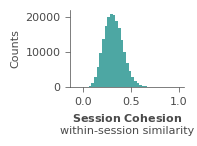

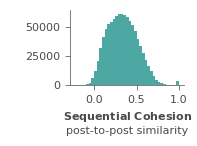

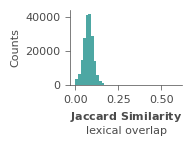

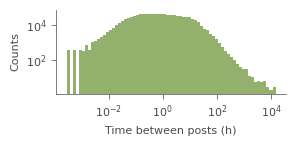

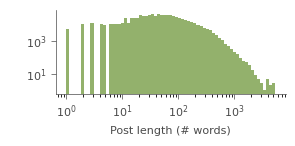

In [17]:
# === FULL HUMAN DATASET PLOTS ===

plt.rcParams.update({'font.size': 8})

# Session cohesion
pu.plot_histogram(session_cohesion_all_human,
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Session\ Cohesion}$' + '\nwithin-session similarity')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_session_cohesion.png', transparent=True)

# Sequential cohesion
pu.plot_histogram(sequential_cohesion_all_human,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Sequential\ Cohesion}$' + '\npost-to-post similarity')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_sequential_cohesion.png', transparent=True)

# DSI
#pu.plot_histogram(dsi_all_human,
#               ylabel="   ",
#               figsize=(2, 1.5),
#               bins=40,
#               alpha=0.8,
#               xlabel=r'$\mathbf{DSI}$' + '\nDivergent Semantic Integration')
#plt.tight_layout()
#plt.savefig(OUTPUT_DIR / 'all_human_dsi.png', transparent=True)

# DSI Emergence
#pu.plot_histogram(dsi_emergence_all_human,
#               ylabel="   ",
#               figsize=(2, 1.5),
#               bins=40,
#               alpha=0.8,
#               xlabel=r'$\mathbf{DSI\ Emergence}$' + '\ngroup - individual diversity')
#plt.tight_layout()
#plt.savefig(OUTPUT_DIR / 'all_human_dsi_emergence.png', transparent=True)

# Jaccard similarity
pu.plot_histogram(jaccard_all_human,
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Jaccard\ Similarity}$' + '\nlexical overlap')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_jaccard.png', transparent=True)

# Time intervals
pu.plot_histogram(time_intervals_all_human,
               figsize=(3, 1.5),
               log_y=True,
               bins=70,
               colors=[[.4, 0.57, .18]],
               alpha=0.7,
               log_bins=True,
               xlabel='Time between posts (h)')
plt.tight_layout()

# Post lengths
pu.plot_histogram(post_lengths_all_human,
               colors=[[.4, 0.57, .18]],
               figsize=(3, 1.5),
               alpha=0.7,
               ylabel="   ",
               log_y=True,
               bins=70,
               log_bins=True,
               xlabel='Post length (# words)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_post_lengths.png', transparent=True)

# Metric Correlation Analysis

Compute correlations between campaign-level metric means to understand which metrics capture unique vs. redundant information.

Correlation matrix computed from 984 campaigns


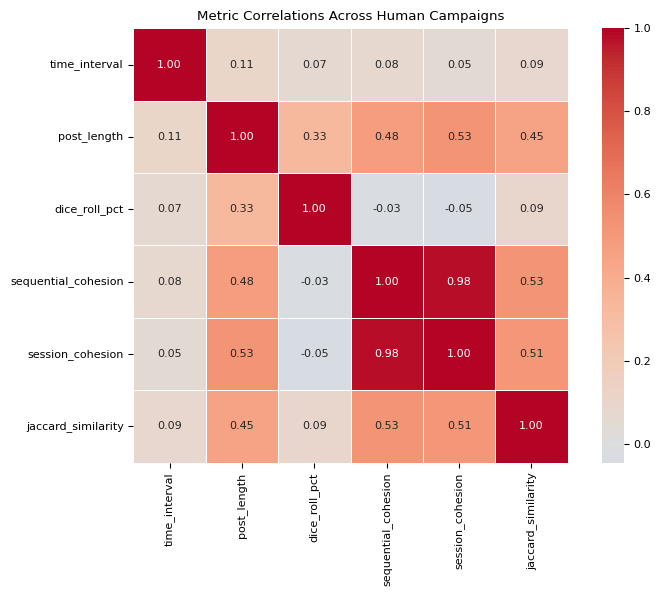

In [18]:
# === METRIC CORRELATION ANALYSIS ===
import seaborn as sns

# Build DataFrame with campaign-level means using new MetricResult API
correlation_data = []

for name in human_names:
    row = {
        'campaign': name,
        'time_interval': basic_metrics_all_human[name].summary['mean_time_interval'],
        'post_length': basic_metrics_all_human[name].summary['mean_post_length'],
        'dice_roll_pct': basic_metrics_all_human[name].summary['dice_roll_pct'],
        'sequential_cohesion': semantic_metrics_all_human[name].summary['mean_sequential_cohesion'],
        'session_cohesion': semantic_metrics_all_human[name].summary['mean_session_cohesion'],
        #'dsi': dsi_metrics_all_human[name].summary['time_averaged_dsi'],
    }
    # Handle potential None for jaccard
    if jaccard_metrics_all_human[name] is not None:
        row['jaccard_similarity'] = jaccard_metrics_all_human[name].summary['mean_jaccard']
    else:
        row['jaccard_similarity'] = np.nan

    correlation_data.append(row)

corr_df = pd.DataFrame(correlation_data)

# Compute correlation matrix (exclude campaign name column)
metric_cols = ['time_interval', 'post_length', 'dice_roll_pct',
               'sequential_cohesion', 'session_cohesion', 'jaccard_similarity'] #'dsi']
corr_matrix = corr_df[metric_cols].corr()

# Plot with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Metric Correlations Across Human Campaigns')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'metric_correlations.png', dpi=300)

print(f"Correlation matrix computed from {len(corr_df)} campaigns")